## Field Profitability Index Prediction
---

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set_theme()

In [3]:
esdc_raw = pd.read_excel('Data/esdc_raw.xlsx')
esdc_raw.head()

,fluid,field_name,operator,project_status,project_level,inplace,depth,temp,poro,perm,...,api_dens,visc,cap_cost,opr_cost,total_cost,avg_fluid_rate,location,region,NPV,PI
0,Gas,ALAS TUA WEST,EXXONMOBIL CEPU LTD.,ONSHORE,X1. Discovery under Evaluation,280.00,5627.0,NaN,0.231540,396.2948,...,0.654735,0.0,88.121670,7.390892,95.512562,61.136190,Jawa Timur,Jawa,219.373400,2.296802
1,Gas,APNC,PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA,OFFSHORE,X3. Development Not Viable,5.00,1588.0,NaN,0.371649,975.0449,...,0.769757,0.0,16.350820,0.482584,16.833404,8.260639,Jawa Barat,Jawa,6.763115,0.401768
2,Gas,APNX,PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA,OFFSHORE,X3. Development Not Viable,17.31,NaN,NaN,0.350870,1985.5620,...,0.774667,0.0,31.212980,5.444560,36.657540,0.209892,Jawa Barat,Jawa,25.005370,0.682134
3,Gas,BEKAPAI,PT PERTAMINA HULU MAHAKAM,BOTH,E8. Further Development Not Viable,7135.00,6383.0,76.45,0.201267,619.7617,...,0.783749,0.0,7.269243,15.765420,23.034663,15.833870,Selat Makasar,Kalimantan,3.810051,0.165405
4,Gas,BENTU DEEP,EMP BENTU LTD.,ONSHORE,X1. Discovery under Evaluation,15.90,2067.0,NaN,0.213011,108.1771,...,0.710626,0.0,6.147158,1.867879,8.015037,6.929915,Riau,Sumatera,112.446500,14.029442


In [4]:
esdc_raw.PI.count()

790

---
__Data Preprocessing__

In [5]:
total = esdc_raw.isnull().sum().sort_values(ascending=False)
percent = (esdc_raw.isnull().sum()/esdc_raw.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
temp,392,49.620253
depth,128,16.202532
region,56,7.088608
field_name,1,0.126582
fluid,0,0.000000
visc,0,0.000000
NPV,0,0.000000
location,0,0.000000
avg_fluid_rate,0,0.000000
total_cost,0,0.000000


> We have 4 major missing values. In oil and gas industry those top 3 variables are crucial because they are often related to development cost and then PI. To obtain a realiable model in PI prediction we decided to solve these issues

_Region_

> We notice that 56 region's data are missing, but when we look at those data we find it is difficult to tie the region by using another features. Despite missing values we decide to exclude those 56 data from dataset because they just represent arround 7% of total. This deletion refeals some dilemmas that we are aiming to use as many as possible datas but we are bounded to classification problem that the model we are aiming to make is capable in making prediction in PI value for a certain region so we conclude that inputation in region could lead to model degradation and quality issue.

In [6]:
esdc_raw = esdc_raw.loc[~esdc_raw.region.isna(), :]

_Temperature & Depth_

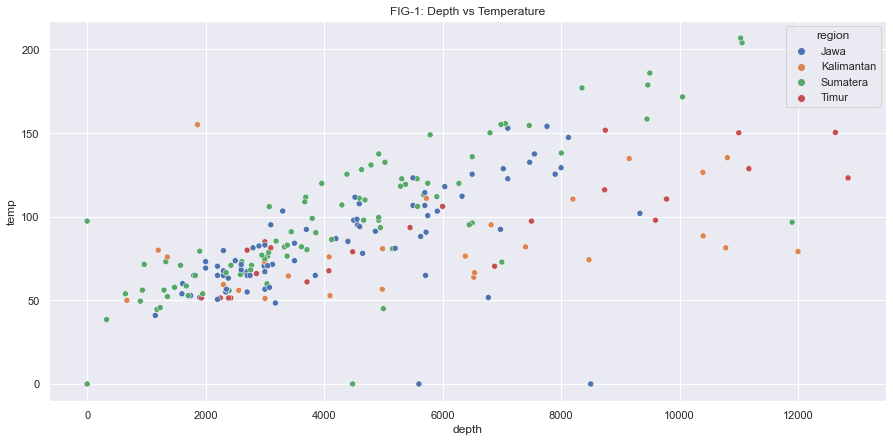

In [7]:
sns.scatterplot(x=esdc_raw.depth, y=esdc_raw.loc[~esdc_raw.temp.isna(), 'temp'], hue=esdc_raw.region)
plt.title('FIG-1: Depth vs Temperature');

> `Depth` has strong relation to `temp` as the drill string going deeper and so does the temperature. We can use this natural phenomena to predict temperature by using `depth`. As predictor, we have to solve `depth` at first to eliminate those missing datas, inconsistencies & outliers.

> FIG-2 shows the depth distribution for indonesian oil & gas field (reservoir) categorized by their location and project status whether it is located on offshore or onshore or both. From FIG-2 we are informed that the depth could vary depending on its location and region.

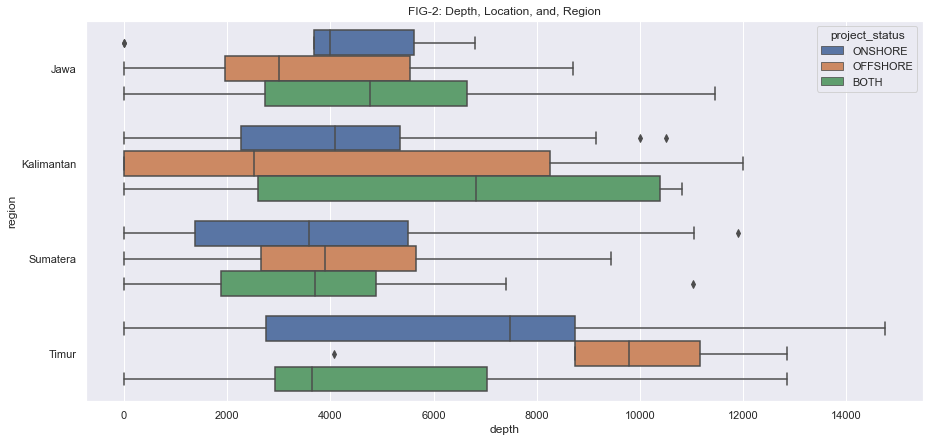

In [8]:
sns.boxplot(x=esdc_raw.depth, y=esdc_raw.region, hue=esdc_raw.project_status)
plt.title('FIG-2: Depth, Location, and, Region');

> On FIG-2 we notice that some anomalies exist and need to be solved. First issue relate to depth that has value == 0 which is impossible to have such shallow oil/ gas deposite so we will replace those values as well as NAN (second issue) by using region-project_status clustered median. We believe median is suitable as replacement because based on business knowledge those value are consistent. Moving to eastern Indonesia we are expecting deeper sea and reservoir but not in Jawa-Kalimantan-Sumatera whose median values are quite similar.

> The code below aims to calculate median value of `depth` for each region and their `project_status`. This code excludes depth==0 to obtain the right median values

In [9]:
jawa = esdc_raw.loc[(esdc_raw.depth != 0) & (esdc_raw.region == 'Jawa')].groupby('project_status')['depth'].median()
kalimantan = esdc_raw.loc[(esdc_raw.depth != 0) & (esdc_raw.region == 'Kalimantan')].groupby('project_status')['depth'].median()
sumatera = esdc_raw.loc[(esdc_raw.depth != 0) & (esdc_raw.region == 'Sumatera')].groupby('project_status')['depth'].median()
timur = esdc_raw.loc[(esdc_raw.depth != 0) & (esdc_raw.region == 'Timur')].groupby('project_status')['depth'].median()

> By having Grouby variable on region code above we are able to inpute median value to replace either NaN and 0 on `depth`. The code below show how it is done

In [10]:
esdc_raw.loc[((esdc_raw.depth == 0) | (esdc_raw.depth.isna())), 'depth'] = esdc_raw.apply(lambda row: jawa[row['project_status']] if (row['region'] == 'Jawa')  else
                    kalimantan[row['project_status']] if (row['region'] == 'Kalimantan') else
                    sumatera[row['project_status']] if (row['region'] == 'Sumatera') else
                    timur[row['project_status']] if (row['region'] == 'Timur') else row['depth'], axis=1)

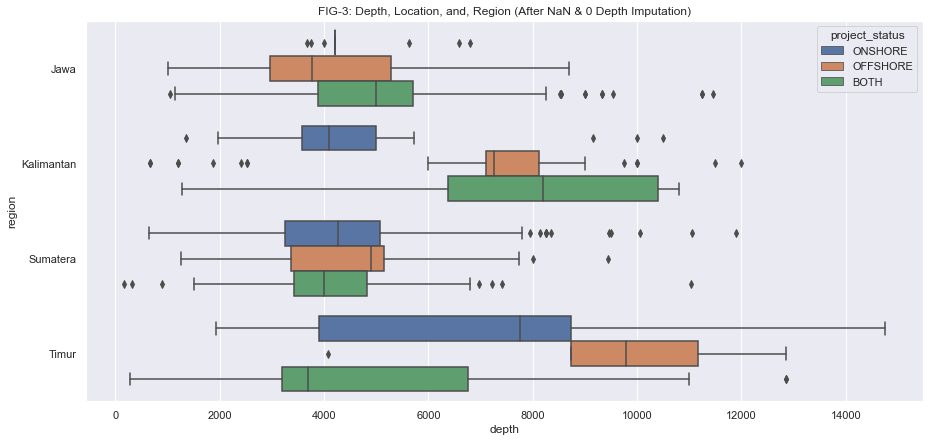

In [11]:
sns.boxplot(x=esdc_raw.depth, y=esdc_raw.region, hue=esdc_raw.project_status)
plt.title('FIG-3: Depth, Location, and, Region (After NaN & 0 Depth Imputation)');

> Sanitiy Check after 0 & NaN `depth` imputation

In [12]:
esdc_raw.loc[esdc_raw.depth == 0, ['depth', 'temp', 'location', 'region', 'project_status']].value_counts()

Series([], dtype: int64)

In [13]:
esdc_raw.loc[esdc_raw.depth.isna(), ['depth', 'temp', 'location', 'region', 'project_status']].value_counts()

Series([], dtype: int64)

Temperature

> As mentioned above that `temp` has strong relation with `depth` lineary and this phenomenon has been known and confirmed by geological knowledge and petroleum physics so we are going to predict `temp` and doing inputation for missing value and 0 by using linear regression

> Based on visual and theory representation, we believe the trend of `temp` will follow logaritmic shape so we decide to transform `depth` and `temp` to become logaritmic value

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [15]:
esdc_raw.loc[(~esdc_raw.temp.isna()) & (esdc_raw.temp != 0), ['temp', 'depth']].describe()

,temp,depth
count,262.000000,262.000000
mean,94.028648,5303.801889
std,32.615539,3064.216780
min,38.500000,328.000000
25%,69.300000,2752.500000
50%,88.550000,4678.500000
75%,116.050000,7100.000000
max,206.811000,12845.000000


In [16]:
esdc_raw_log = esdc_raw.loc[(~esdc_raw.temp.isna()) & (esdc_raw.temp != 0), ['temp', 'depth']].apply(lambda x: np.log(x))

In [17]:
esdc_raw_log.describe()

,temp,depth
count,262.000000,262.000000
mean,4.485022,8.381587
std,0.343751,0.670976
min,3.650658,5.793014
25%,4.238445,7.920264
50%,4.483567,8.450730
75%,4.754021,8.867850
max,5.331805,9.460710


In [18]:
mod_1 = ols("temp ~ depth", data = esdc_raw_log)
res_1 = mod_1.fit(cov_type='HC3')
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     295.1
Date:                Mon, 27 Jun 2022   Prob (F-statistic):           1.02e-44
Time:                        08:06:45   Log-Likelihood:                 8.3725
No. Observations:                 262   AIC:                            -12.75
Df Residuals:                     260   BIC:                            -5.608
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3489      0.181      7.469      0.0

> As shown on summary tabel above we quite certain that the linear relationship can be modeled properly judged by some values that underlained linear regression foundation. Those values informed us that the model are the best fitted model available (refer : Gauss-Markov)

> Those values are:
- Durbin watson = Near 2, which is suitable to conclude that our model are not performing some serious autocorrelation
- F-stat (prob) = 1.02e-44, meaning `depth` has strong effect on temperature together with the intercept (< 0.05)
- R-square = 0.532, meaning we can model/ explain more that 50% variance in `temp` by using `depth` alone
- Prob (JB) = 0.407, meaning our model's residual are normaly distributed (> 0.05) and not performing some heteroskedastic
- Multicollinearity = Not tested, but we can conclude this effect is not coming into play because we just use single `depth` variable

In [19]:
esdc_raw['temp'] = esdc_raw.apply(lambda row: np.exp(1.3489 + np.log(row['depth'])*0.3742) if ((np.isnan(row['temp'])) 
                    | (row['temp'] == 0)) else row['temp'], axis=1)

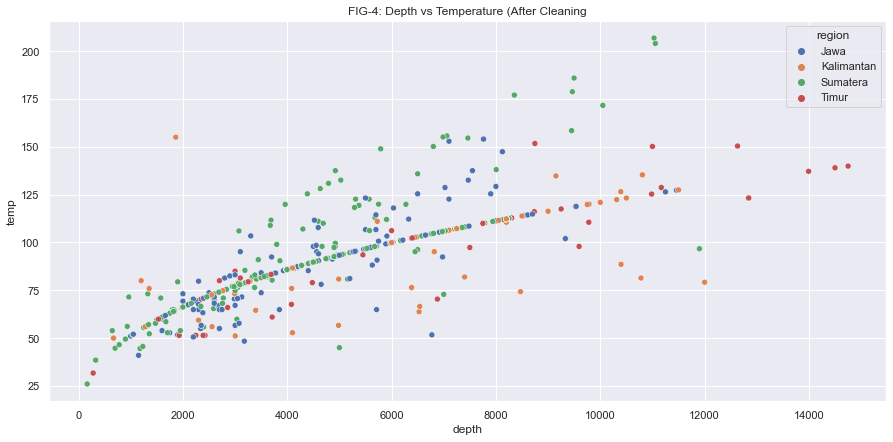

In [20]:
sns.scatterplot(x=esdc_raw.depth, y=esdc_raw.loc[~esdc_raw.temp.isna(), 'temp'], hue=esdc_raw.region)
plt.title('FIG-4: Depth vs Temperature (After Cleaning');

_Field Name_

> We notice that 1 field does'nt have field name but we decide to input this missing value in field_name by using dummy name as PETROGAS_FIELD

In [21]:
esdc_raw.loc[esdc_raw.field_name.isna(), :]

,fluid,field_name,operator,project_status,project_level,inplace,depth,temp,poro,perm,...,api_dens,visc,cap_cost,opr_cost,total_cost,avg_fluid_rate,location,region,NPV,PI
82,Gas,NaN,PETROGAS (BASIN) LTD.,ONSHORE,E0. On Production,15.2,8500.0,113.817329,0.208427,1843.266,...,0.707603,0.0,32.91079,6.594186,39.504976,7.070269,Papua Barat,Timur,12.41523,0.31427


In [22]:
esdc_raw.loc[esdc_raw.field_name.isna(), 'field_name'] = 'PETROGAS_FIELD'

In [23]:
total = esdc_raw.isnull().sum().sort_values(ascending=False)
percent = (esdc_raw.isnull().sum()/esdc_raw.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
fluid,0,0.0
api_dens,0,0.0
NPV,0,0.0
region,0,0.0
location,0,0.0
avg_fluid_rate,0,0.0
total_cost,0,0.0
opr_cost,0,0.0
cap_cost,0,0.0
visc,0,0.0


---
__Data Ready__

In [24]:
esdc_raw.to_csv('Data/esdc_df.csv')

---
__Feature Engineering__

In [25]:
esdc_df = pd.read_csv('Data/esdc_df.csv')
esdc_df.drop(columns='Unnamed: 0', inplace=True)
esdc_df.head()

,fluid,field_name,operator,project_status,project_level,inplace,depth,temp,poro,perm,...,api_dens,visc,cap_cost,opr_cost,total_cost,avg_fluid_rate,location,region,NPV,PI
0,Gas,ALAS TUA WEST,EXXONMOBIL CEPU LTD.,ONSHORE,X1. Discovery under Evaluation,280.00,5627.0,97.537911,0.231540,396.2948,...,0.654735,0.0,88.121670,7.390892,95.512562,61.136190,Jawa Timur,Jawa,219.373400,2.296802
1,Gas,APNC,PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA,OFFSHORE,X3. Development Not Viable,5.00,1588.0,60.754449,0.371649,975.0449,...,0.769757,0.0,16.350820,0.482584,16.833404,8.260639,Jawa Barat,Jawa,6.763115,0.401768
2,Gas,APNX,PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA,OFFSHORE,X3. Development Not Viable,17.31,3775.0,84.004423,0.350870,1985.5620,...,0.774667,0.0,31.212980,5.444560,36.657540,0.209892,Jawa Barat,Jawa,25.005370,0.682134
3,Gas,BEKAPAI,PT PERTAMINA HULU MAHAKAM,BOTH,E8. Further Development Not Viable,7135.00,6383.0,76.450000,0.201267,619.7617,...,0.783749,0.0,7.269243,15.765420,23.034663,15.833870,Selat Makasar,Kalimantan,3.810051,0.165405
4,Gas,BENTU DEEP,EMP BENTU LTD.,ONSHORE,X1. Discovery under Evaluation,15.90,2067.0,67.053312,0.213011,108.1771,...,0.710626,0.0,6.147158,1.867879,8.015037,6.929915,Riau,Sumatera,112.446500,14.029442


> _PI Engineering_

In [26]:
esdc_df.project_level.value_counts()

E7. Production Not Viable             132
E0. On Production                     122
X1. Discovery under Evaluation        112
E6. Further Development                74
E4. Production Pending                 70
E5. Development Unclarified            53
X3. Development Not Viable             42
E3. Justified for Development          36
X0. Development Pending                31
E2. Under Development                  20
X2. Development Undetermined           18
E8. Further Development Not Viable     17
E1. Production on Hold                  7
Name: project_level, dtype: int64

In [27]:
esdc_df.groupby('project_level')['PI'].mean()

project_level
E0. On Production                     2.033117
E1. Production on Hold                3.128682
E2. Under Development                 2.420781
E3. Justified for Development         0.849384
E4. Production Pending                0.965692
E5. Development Unclarified           1.459044
E6. Further Development               1.223655
E7. Production Not Viable             0.749261
E8. Further Development Not Viable    2.094478
X0. Development Pending               1.240810
X1. Discovery under Evaluation        1.220731
X2. Development Undetermined          0.850525
X3. Development Not Viable            0.584434
Name: PI, dtype: float64

> Based on dataset that we have, we agree that those PI values ranging in numerical manner. We believe that having this number on high level evaluation/ predictive model output are not informative so we decide to categorize those elements by using unique name related to their prospect as : High, Med, and NonPros. To simplify the modeling process we replace those value to become : High = 2, Med = 1, and NonPros = 0.

> The naming process begins by doing some analysis to find mean value for each `project_level`. We believe that `project_level` has strong relation to `PI` because we can spot the differences on their mean related to their level. For instance, E0 when fields are categorized as "On Production" meaning those field has already produced and delivered a cashflow (projects are profitable) has mean `PI` value as high as 2 (profitable). We agree that this visual segmentation process is prone to bias because it is not supported by statistical analysis related to their dataset.

> To make an objective studies and deliver a reliable model we are going to use statistical analysis to support out segmentation process in separating `PI` adjacent to their `project_level` by assuming their distribution are normal distribution (FIG-5). This process begin by doing statistical significant analysis sequentially as follow:
- Separate HIGH from MED + NonPros (is it HIGH significant by mean value from 2 others?)
- Separate MED from NonPros (is it MED significant by mean value from NonPros?)

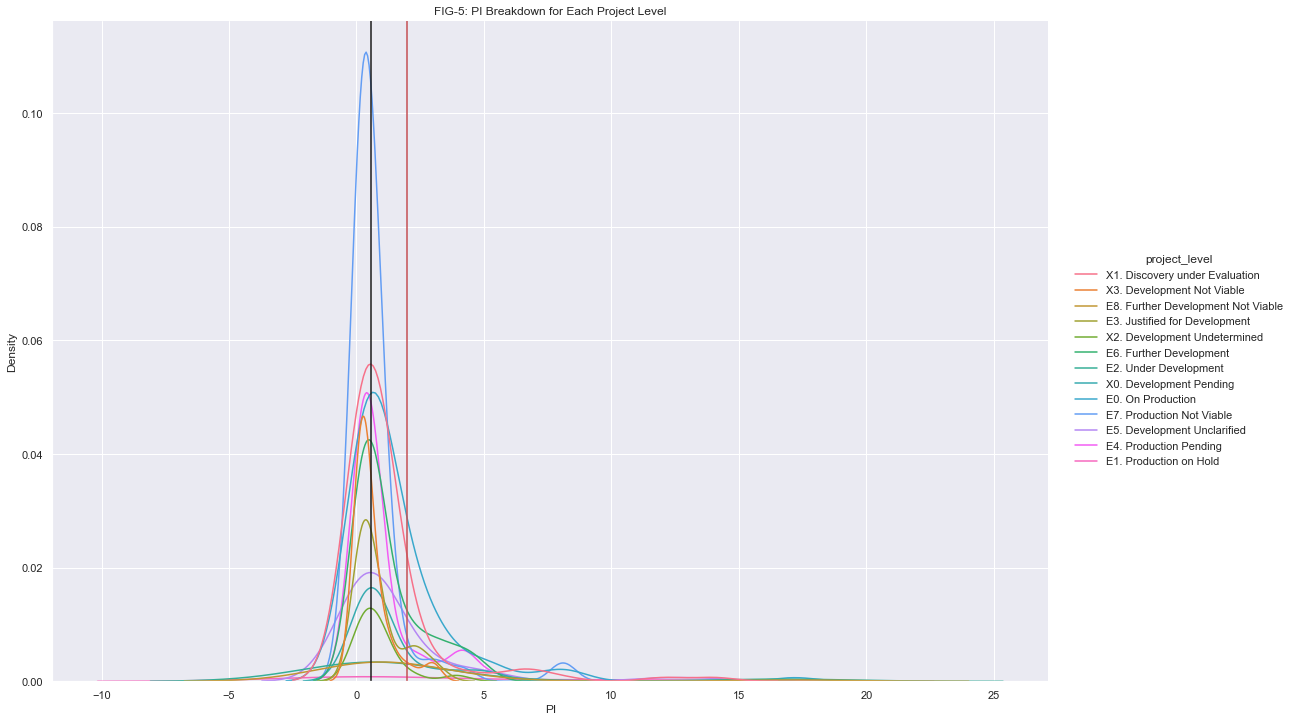

In [28]:
sns.displot(x='PI', hue='project_level', data=esdc_df.loc[esdc_df.PI <= 20, :], height=10, aspect=1.5, kind='kde')

plt.axvline(2, c='r')
plt.axvline(0.58, c='k')
plt.title('FIG-5: PI Breakdown for Each Project Level');

> Statistical significant test will be conducting using t-test. In order to perform such test we will generate new feature to accomodate prospect rank as mentioned above (High=2, Med=1, and NonPros=0), this feature will be called `prospect_rank`


> That feature are related to `project_level` segmented by their `PI` mean value. For clarity we show the segementation in detail just below:
- High = 2 --> E0, E1, E2, and E8
- Med = 1 --> E3, E4, E5, E6, X0, X1, X2
- NonPros = 0 --> E7 & X3

In [29]:
esdc_df['prospect_rank'] = esdc_df.apply(lambda row: 2 if ((row['project_level'] == 'E0. On Production') | (row['project_level'] == 'E1. Production on Hold')
                        | (row['project_level'] == 'E2. Under Development') | (row['project_level'] == 'E8. Further Development Not Viable')) else 0
                        if ((row['project_level'] == 'E7. Production Not Viable') | (row['project_level'] == 'X3. Development Not Viable')) else 1, axis=1)

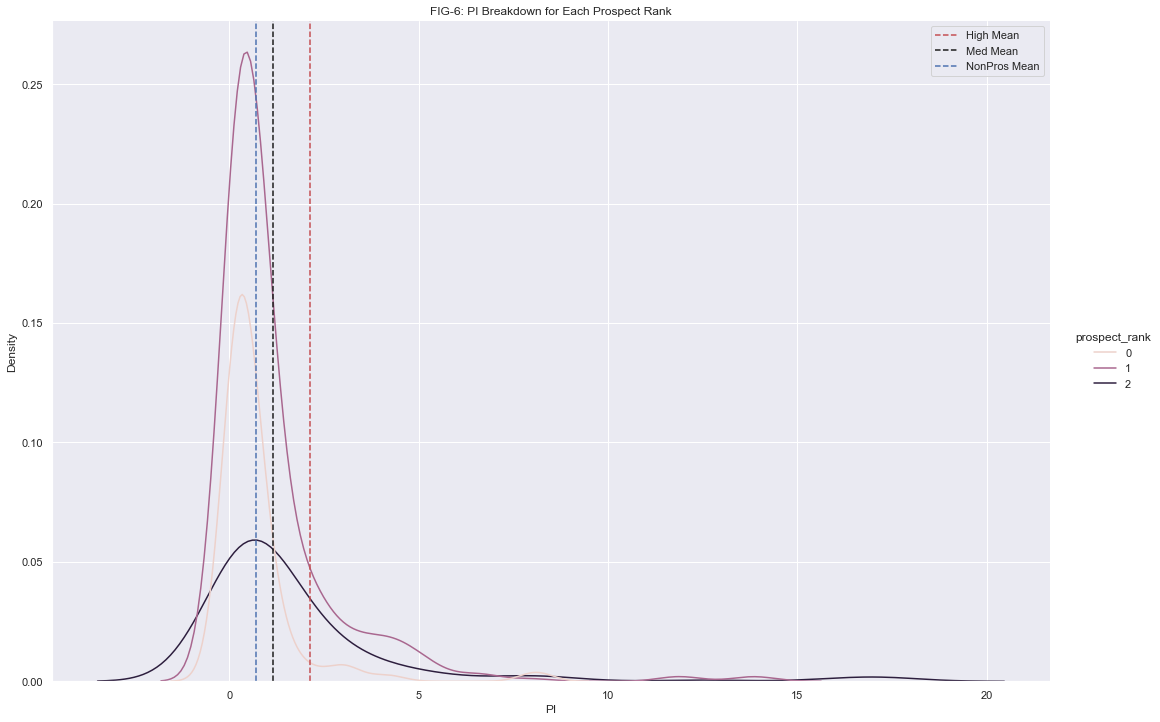

In [30]:
sns.displot(x='PI', hue='prospect_rank', data=esdc_df.loc[esdc_df.PI <= 20, :], height=10, aspect=1.5, kind='kde')

plt.axvline(2.132306, c='r', label='High Mean', ls='--')
plt.axvline(1.158763, c='k', label = 'Med Mean', ls='--')
plt.axvline(0.709475, c='b', label= 'NonPros Mean', ls='--')
plt.legend()


plt.title('FIG-6: PI Breakdown for Each Prospect Rank');

In [31]:
from joypy import joyplot

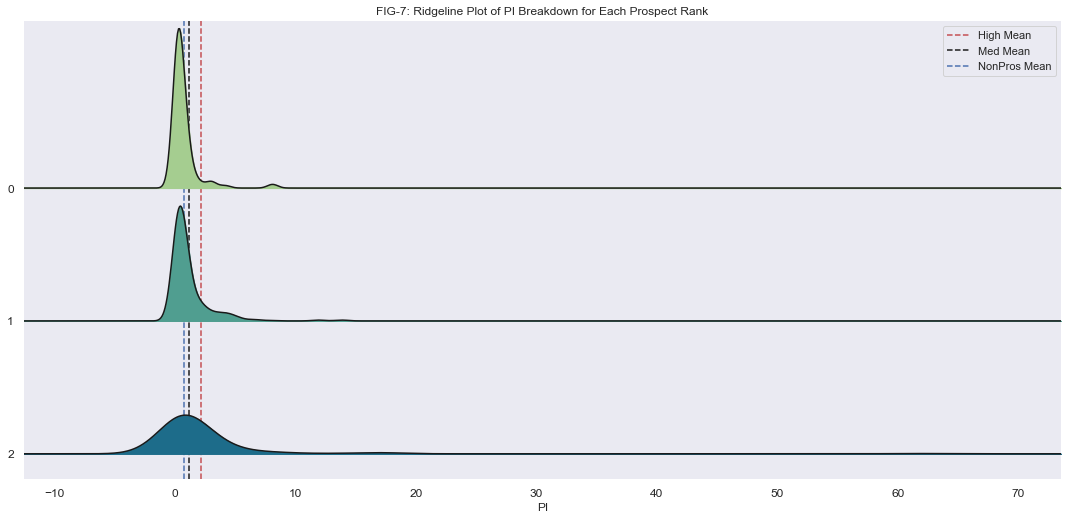

In [32]:
joyplot(esdc_df, by='prospect_rank', column='PI', colormap=sns.color_palette('crest', as_cmap=True))

plt.axvline(2.132306, c='r', label='High Mean', ls='--')
plt.axvline(1.158763, c='k', label = 'Med Mean', ls='--')
plt.axvline(0.709475, c='b', label= 'NonPros Mean', ls='--')
plt.legend()

plt.xlabel('PI')
plt.title('FIG-7: Ridgeline Plot of PI Breakdown for Each Prospect Rank');

In [33]:
esdc_df.loc[esdc_df.PI <= 5, :].groupby('prospect_rank')['PI'].mean()

prospect_rank
0    0.579784
1    0.921132
2    1.011531
Name: PI, dtype: float64

In [34]:
esdc_df.groupby('prospect_rank')['PI'].mean()

prospect_rank
0    0.709475
1    1.158763
2    2.132306
Name: PI, dtype: float64

> From joyplot on FIG-7 & 2 codes above we can spot the differences between those 3 data distribution when single mean value might be not representative to be used on statistical significant analysis (independence) as each of them having fat tailed distribution. To overcome this issue we are going to conduct multiple significant test known as t-Test, ChiSquared Test, f-Test, and The Kruskal-Wallis H-Test.

In [35]:
from scipy import stats

t-Test:

>This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default
>> 1. Separating 2 from 1 & 0

In [36]:
stats.ttest_ind(esdc_df.loc[esdc_df.prospect_rank == 2, 'PI'], esdc_df.loc[~(esdc_df.prospect_rank == 2), 'PI'],
                equal_var=False)

Ttest_indResult(statistic=2.5626258876008614, pvalue=0.01123801518556235)

> If we assumed that p-value cut-off to infer conclusion (rejecting null) from data as high as 0.05 (5%) then from our calculation shown on code above we can conclude that from the data we have and segmentation we did between 2 & (1+0), we are able to separate 2 as it has independencies (statiscally speaking) from others.

>> 2. Separating 1 from 0

In [37]:
stats.ttest_ind(esdc_df.loc[esdc_df.prospect_rank == 1, 'PI'], esdc_df.loc[esdc_df.prospect_rank == 0, 'PI'],
                equal_var=False)

Ttest_indResult(statistic=3.514572488953012, pvalue=0.00048341526078993024)

> If we assumed that p-value cut-off to infer conclusion (rejecting null) from data as high as 0.05 (5%) then from our calculation shown on code above we can conclude that from the data we have and segmentation we did between 1 & 0, we are able to separate 1 as it has independencies (statiscally speaking) from 0.

Chi-Squared Test:

>This is a test for the null hypothesis that 2 independent samples. One of the least known applications of the chi-squared test is "testing the similarity between two distributions". If the two distributions were the same, we would expect the same frequency of observations in each bin. Please remember, this is a test for whole distribution shape not just mean value as t-Test did to conclude whether 2 datas along with their distribution are different statisticaly.

>The reason lies in the fact that the two distributions have a similar center but different tails and the chi-squared test tests the similarity along the whole distribution and not only in the center, as we were doing with the previous tests

>> 1. Separating 2 from 1 & 0

In [38]:
# Init dataframe
df_bins = pd.DataFrame()

# Generate bins from control group
_, bins = pd.qcut(esdc_df.loc[esdc_df.prospect_rank == 2, 'PI'], q=10, retbins=True)
df_bins['bin'] = pd.cut(esdc_df.loc[esdc_df.prospect_rank == 2, 'PI'], bins=bins).value_counts().index

# Apply bins to both groups
df_bins['2'] = pd.cut(esdc_df.loc[esdc_df.prospect_rank == 2, 'PI'], bins=bins).value_counts().values #As Treatment 
df_bins['0&1'] = pd.cut(esdc_df.loc[~(esdc_df.prospect_rank == 2), 'PI'], bins=bins).value_counts().values #As Control

# Compute expected frequency in the treatment group
df_bins['expected'] = df_bins['0&1'] / np.sum(df_bins['2']) * np.sum(df_bins['0&1'])

df_bins

,bin,2,0&1,expected
0,"(0.0928, 0.242]",17,98,336.169697
1,"(0.242, 0.355]",17,91,312.157576
2,"(0.77, 1.028]",17,72,246.981818
3,"(1.574, 2.377]",17,61,209.248485
4,"(4.082, 61.263]",17,54,185.236364
5,"(-0.204, 0.0928]",16,51,174.945455
6,"(0.355, 0.563]",16,43,147.503030
7,"(0.563, 0.77]",16,37,126.921212
8,"(1.028, 1.574]",16,32,109.769697
9,"(2.377, 4.082]",16,27,92.618182


In [39]:
from scipy.stats import chisquare

In [40]:
chisquare(df_bins['2'], df_bins['expected'])

Power_divergenceResult(statistic=1627.7605047220818, pvalue=0.0)

> If we assumed that p-value cut-off to infer conclusion (rejecting null) from data as high as 0.05 (5%) then from our calculation shown on code above we can conclude that from the data we have and segmentation we did between 2 & (1+0), we are able to separate 2 as it has independencies (statiscally speaking) from others.

>> 2. Separating 1 from 0

In [41]:
# Init dataframe
df_bins = pd.DataFrame()

# Generate bins from control group
_, bins = pd.qcut(esdc_df.loc[esdc_df.prospect_rank == 1, 'PI'], q=10, retbins=True)
df_bins['bin'] = pd.cut(esdc_df.loc[esdc_df.prospect_rank == 1, 'PI'], bins=bins).value_counts().index

# Apply bins to both groups
df_bins['1'] = pd.cut(esdc_df.loc[esdc_df.prospect_rank == 1, 'PI'], bins=bins).value_counts().values #As Treatment 
df_bins['0'] = pd.cut(esdc_df.loc[(esdc_df.prospect_rank == 0), 'PI'], bins=bins).value_counts().values #As Control

# Compute expected frequency in the treatment group
df_bins['expected'] = df_bins['0'] / np.sum(df_bins['1']) * np.sum(df_bins['0'])

df_bins

,bin,1,0,expected
0,"(0.295, 0.417]",40,32,14.086514
1,"(0.555, 0.774]",40,25,11.005089
2,"(2.998, 14.029]",40,25,11.005089
3,"(-0.204, 0.11]",39,20,8.804071
4,"(0.11, 0.18]",39,15,6.603053
5,"(0.18, 0.295]",39,15,6.603053
6,"(0.417, 0.555]",39,15,6.603053
7,"(0.774, 0.986]",39,12,5.282443
8,"(0.986, 1.658]",39,8,3.521628
9,"(1.658, 2.998]",39,6,2.641221


In [42]:
chisquare(df_bins['1'], df_bins['expected'])

Power_divergenceResult(statistic=1854.0258810248718, pvalue=0.0)

> If we assumed that p-value cut-off to infer conclusion (rejecting null) from data as high as 0.05 (5%) then from our calculation shown on code above we can conclude that from the data we have and segmentation we did between 1 & 0, we are able to separate 1 as it has independencies (statiscally speaking) from 0.

f-Test:

> With multiple groups, the most popular test is the F-test. The F-test compares the variance of a variable across different groups. This analysis is also called analysis of variance, or ANOVA

> The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid:

- The samples are independent.
- Each sample is from a normally distributed population.
- The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

In [43]:
from scipy.stats import f_oneway

In [44]:
stats.f_oneway(esdc_df.loc[esdc_df.prospect_rank == 2, 'PI'], esdc_df.loc[(esdc_df.prospect_rank == 1), 'PI'],
                esdc_df.loc[(esdc_df.prospect_rank == 0), 'PI'])

F_onewayResult(statistic=10.294045218404696, pvalue=3.900781179669663e-05)

> The f-Test p-value is less than 0.05 (5%), implying a strong rejection of the null hypothesis of no differences in the `PI` distribution across `prospect_rank`

The Kruskal-Wallis H-test:

> Because the last assumption of f-Test are not fulfiled we add last test (The Kruskal-Wallis) to confirm independencies

> The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes.

In [45]:
stats.kruskal(esdc_df.loc[esdc_df.prospect_rank == 2, 'PI'], esdc_df.loc[(esdc_df.prospect_rank == 1), 'PI'],
                esdc_df.loc[(esdc_df.prospect_rank == 0), 'PI'])

KruskalResult(statistic=28.31055333294545, pvalue=7.119368192553384e-07)

> Still, The p-value is significantly less than 0.05 (5%), implying a strong rejection of the null hypothesis of no differences in the `PI` distribution across `prospect_rank`

> _Operatorship Engineering_

In [46]:
pd.options.display.max_columns = None
esdc_df.head()

,fluid,field_name,operator,project_status,project_level,inplace,depth,temp,poro,perm,saturate,api_dens,visc,cap_cost,opr_cost,total_cost,avg_fluid_rate,location,region,NPV,PI,prospect_rank
0,Gas,ALAS TUA WEST,EXXONMOBIL CEPU LTD.,ONSHORE,X1. Discovery under Evaluation,280.00,5627.0,97.537911,0.231540,396.2948,0.544649,0.654735,0.0,88.121670,7.390892,95.512562,61.136190,Jawa Timur,Jawa,219.373400,2.296802,1
1,Gas,APNC,PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA,OFFSHORE,X3. Development Not Viable,5.00,1588.0,60.754449,0.371649,975.0449,0.586189,0.769757,0.0,16.350820,0.482584,16.833404,8.260639,Jawa Barat,Jawa,6.763115,0.401768,0
2,Gas,APNX,PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA,OFFSHORE,X3. Development Not Viable,17.31,3775.0,84.004423,0.350870,1985.5620,0.627856,0.774667,0.0,31.212980,5.444560,36.657540,0.209892,Jawa Barat,Jawa,25.005370,0.682134,0
3,Gas,BEKAPAI,PT PERTAMINA HULU MAHAKAM,BOTH,E8. Further Development Not Viable,7135.00,6383.0,76.450000,0.201267,619.7617,0.681374,0.783749,0.0,7.269243,15.765420,23.034663,15.833870,Selat Makasar,Kalimantan,3.810051,0.165405,2
4,Gas,BENTU DEEP,EMP BENTU LTD.,ONSHORE,X1. Discovery under Evaluation,15.90,2067.0,67.053312,0.213011,108.1771,0.701410,0.710626,0.0,6.147158,1.867879,8.015037,6.929915,Riau,Sumatera,112.446500,14.029442,1


> We dont need all operators name on this analysis because we believe it will not deliver significant information regarding field economic. Instead, we are going to replace those name by Pertamina & Non-Pertamina to separate NoC and others.

In [47]:
pd.options.display.max_rows = None

In [48]:
esdc_df.operator.value_counts()

PT PERTAMINA EP                                      186
PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA     63
PT PERTAMINA HULU MAHAKAM                             39
PT PERTAMINA HULU KALIMANTAN TIMUR                    32
PT PERTAMINA HULU ROKAN                               23
CONOCOPHILLIPS (GRISSIK) LTD.                         22
MEDCO E&P NATUNA LTD.                                 20
PREMIER OIL NATUNA SEA B.V.                           17
PT PERTAMINA HULU ENERGI OSES                         15
PETROGAS (BASIN) LTD.                                 14
BP BERAU LTD.                                         14
PETROCHINA INTERNATIONAL JABUNG LTD.                  13
PT MEDCO E&P INDONESIA                                12
PT PERTAMINA HULU ENERGI WEST MADURA OFFSHORE         11
EMP MALACCA STRAIT S.A.                                9
JOB PERTAMINA - MEDCO E&P SIMENGGARIS                  9
PT PERTAMINA HULU ENERGI NORTH SUMATERA OFFSHORE       8
PT. Pertamina Hulu Energi (PHE)

In [49]:
esdc_df['operator'] = esdc_df.apply(lambda row: 'PERTAMINA' if ('PERTAMINA' in row['operator']) else 'NON_PERTAMINA', axis=1)

In [50]:
esdc_df.operator.value_counts()

PERTAMINA        432
NON_PERTAMINA    302
Name: operator, dtype: int64

---
__Features Droping__

> Based on analysis that has been done we will drop some features that are not relevant anymore for further evaluation and modeling. Those features were critical when we modeled the `depth`, `temp`, `prospect_rank` and performed statistical independence test. Those features are :
- `field_name`
- `project_level`
- `cap_cost`
- `opr_cost`
- `total_cost`
- `NPV`
- `PI`

In [51]:
esdc_feat_df = esdc_df.drop(columns=['field_name', 'project_level', 'cap_cost', 'opr_cost','total_cost', 'NPV', 'PI'])

---
__Unit Conversion__

> We will modified some features unit to make it more representative and consistent. Below is the list of those features and their unit:
- inplace (Oil in MSTB, Gas in BSCF, and Oil_Gas in MSTB), will be modified to MMBO.E
- depth (feet) ??
- temp (fahrenheit) ??
- poro (dimensionless)
- perm (md)
- saturate (dimensionless)
- api_dens (Oil in API, Gas in Specific Gravity, Oil_Gas in API), no modification is needed since the both unit are dimensionless
- visc (cp), gas visc are negligible (zero) while oil is in centipoise (cp)
- avg_fluid_rate (Oil in BOPD, Gas in MMSCFD, and Oil_Gas in BOPD), will be modified to BOPD.E


In [52]:
esdc_feat_df['inplace'] = esdc_feat_df.apply(lambda row: row['inplace']/1000 if (row['fluid'] == 'Oil') | (row['fluid'] == 'Oil_Gas') 
                        else row['inplace']/5.6, axis=1) #Inplace conversion

esdc_feat_df['avg_fluid_rate'] = esdc_feat_df.apply(lambda row: ((row['avg_fluid_rate']/1000)/5.6)*1000000 if row['fluid'] == 'Gas'
                        else row['avg_fluid_rate'], axis=1) #Rate conversion

In [53]:
esdc_feat_df.to_csv('Data/esdc_feat_df.csv', index=False)

---
__EDA__

In [54]:
pd.read_csv('Data/esdc_feat_df.csv').head()

,fluid,operator,project_status,inplace,depth,temp,poro,perm,saturate,api_dens,visc,avg_fluid_rate,location,region,prospect_rank
0,Gas,NON_PERTAMINA,ONSHORE,50.000000,5627.0,97.537911,0.231540,396.2948,0.544649,0.654735,0.0,10917.176786,Jawa Timur,Jawa,1
1,Gas,PERTAMINA,OFFSHORE,0.892857,1588.0,60.754449,0.371649,975.0449,0.586189,0.769757,0.0,1475.114107,Jawa Barat,Jawa,0
2,Gas,PERTAMINA,OFFSHORE,3.091071,3775.0,84.004423,0.350870,1985.5620,0.627856,0.774667,0.0,37.480696,Jawa Barat,Jawa,0
3,Gas,PERTAMINA,BOTH,1274.107143,6383.0,76.450000,0.201267,619.7617,0.681374,0.783749,0.0,2827.476786,Selat Makasar,Kalimantan,2
4,Gas,NON_PERTAMINA,ONSHORE,2.839286,2067.0,67.053312,0.213011,108.1771,0.701410,0.710626,0.0,1237.484821,Riau,Sumatera,1


__Effect of inplace, avg_fluid_rate & fluid on prospect_rank__

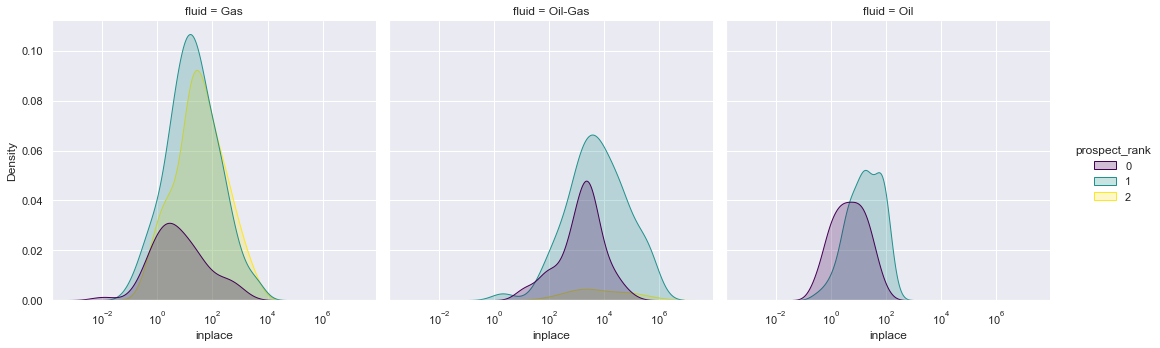

In [55]:
sns.displot(data=esdc_feat_df, x='inplace', col='fluid', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);

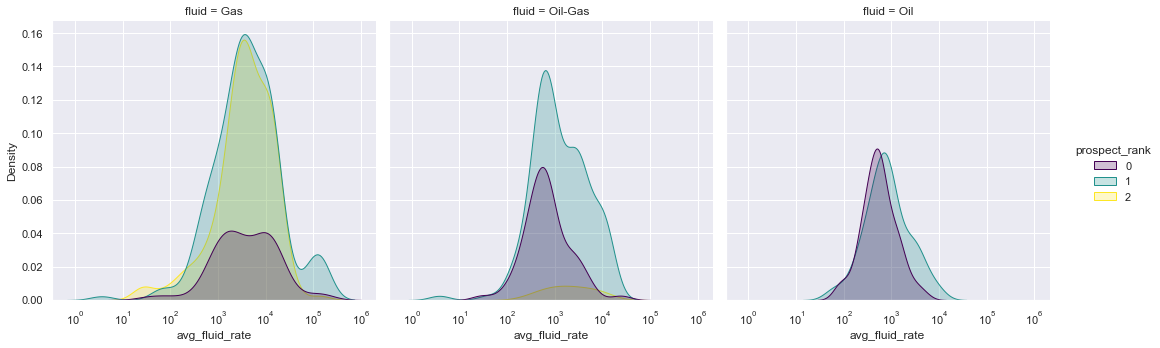

In [56]:
sns.displot(data=esdc_feat_df, x='avg_fluid_rate', col='fluid', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);

> We suspect there is a causal effect of `inplace` & `avg_fluid_rate` in `prospect_rank`. While we segmented on `fluid` we notice that by having bigger `inplace` and `avg_fluid_rate` could lead us to more preferable economic of scale benefit therefore significantly improve our field `prospect_rank` but we notice a high level anomaly on `fluid`==`Gas` where `avg_fluid_rate` are not giving significant impact any more on `prospect_rank`. This issue could be inferred from graph when `prospect_rank` == 0 exists together along `prospect_rank` 1 & 2. This issue need to be addressed in more detail analysis during modeling whether additional features are needed to clarify or not.

__Effect of depth, inplace, rate, and fluid on prospect_rank__

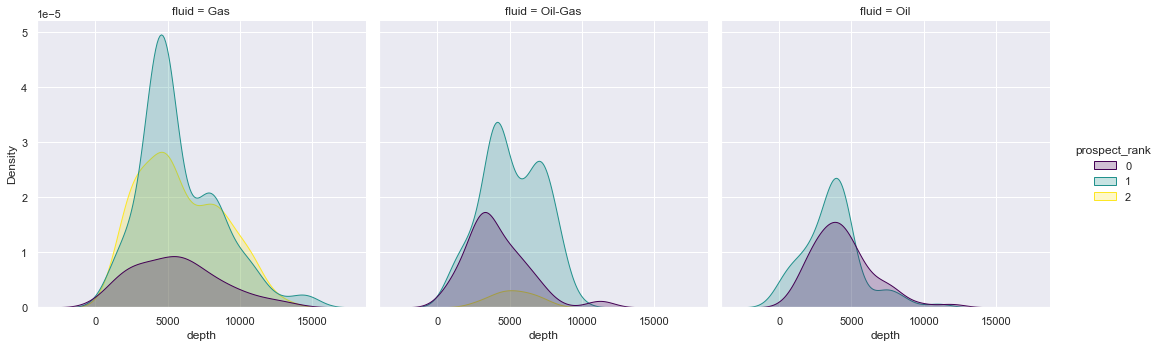

In [57]:
sns.displot(data=esdc_feat_df, x='depth', col='fluid', hue='prospect_rank', kind='kde', fill=True, palette='viridis');

> On above plot, we see minor insight regarding `depth` and its effect on `prospect_rank` while data is segmented by `fluid`. We can infer from high level that neither `fluid` nor `depth` will give significant influences on field prospect, instead most of the field will have better chance to be more economical when `depth` is shallower. Probably, we have to classify the data further by looking to other basic features to get better `prospect_rank` classification.

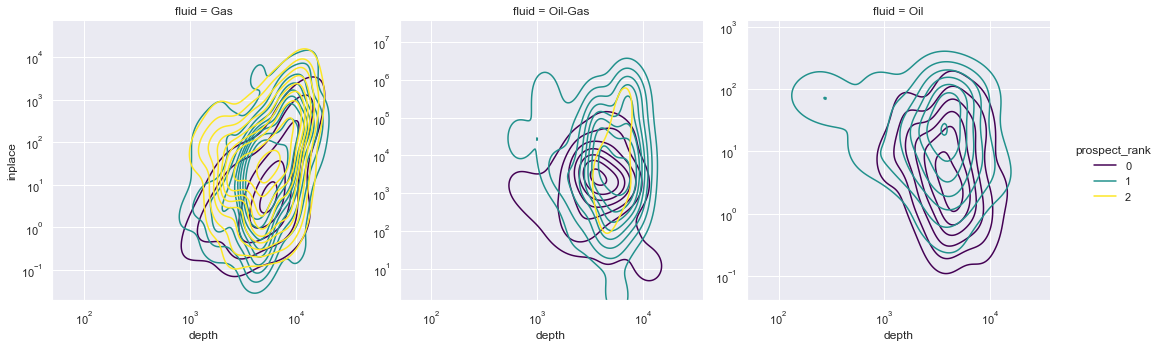

In [58]:
sns.displot(data=esdc_feat_df, y='inplace', x='depth', col='fluid', hue='prospect_rank', kind='kde',
             palette='viridis', log_scale=True, facet_kws=dict(sharey=False));

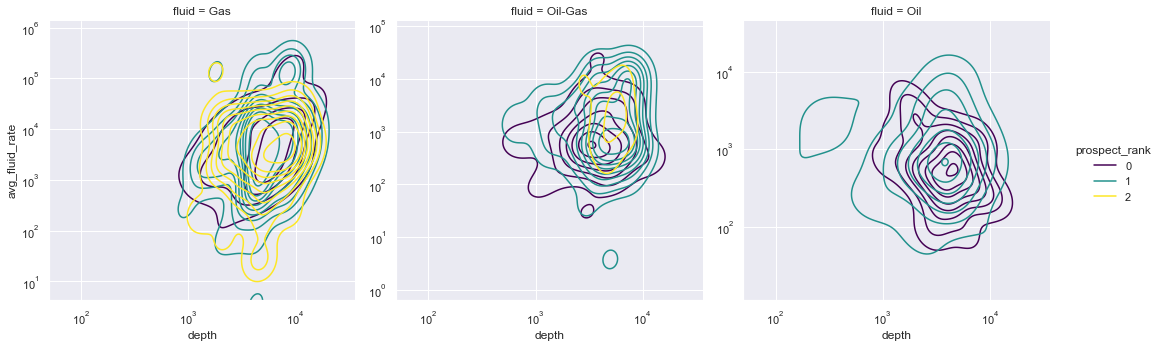

In [59]:
sns.displot(data=esdc_feat_df, y='avg_fluid_rate', x='depth', col='fluid', hue='prospect_rank', kind='kde',
             palette='viridis', log_scale=True, facet_kws=dict(sharey=False));

> More insightful analysis is obtain when we classify `depth` further by using `inplace` and `avg_fluid_rate`. From 2 last plot above we spot meaningful informations that `inplace` and `avg_fluid_rate` play significant role in determining field `prospect_rank`. When fields are having a deeper reservoir target they need either bigger `inplace` or `avg_fluid_rate` in order to become more economical.

> We agree that some anomalies exists, for example on `Gas` where `prospect_rank` are not clasify properly. We believe, although more analysis in ML are needed, that this issue occurs only on `Gas` because sometimes gas production is limited by market potential and could limit their withdrawal rate. This problem could erode economical value in accordance. So, we suspect on `Gas` that either `region` or `location` could play major role to spot non market potential area/ region.

__Effect of inplace, rate, region, and fluid==Gas on prospect_rank__

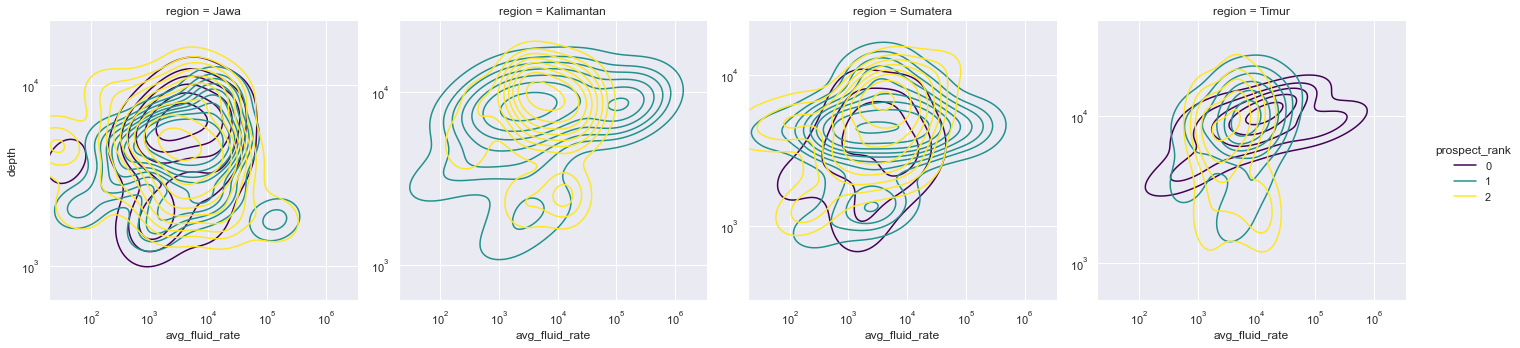

In [60]:
sns.displot(data=esdc_feat_df.loc[esdc_feat_df.fluid == 'Gas', :], x='avg_fluid_rate', y='depth', col='region', hue='prospect_rank', kind='kde',
                palette='viridis', log_scale=True, facet_kws=dict(sharey=False));


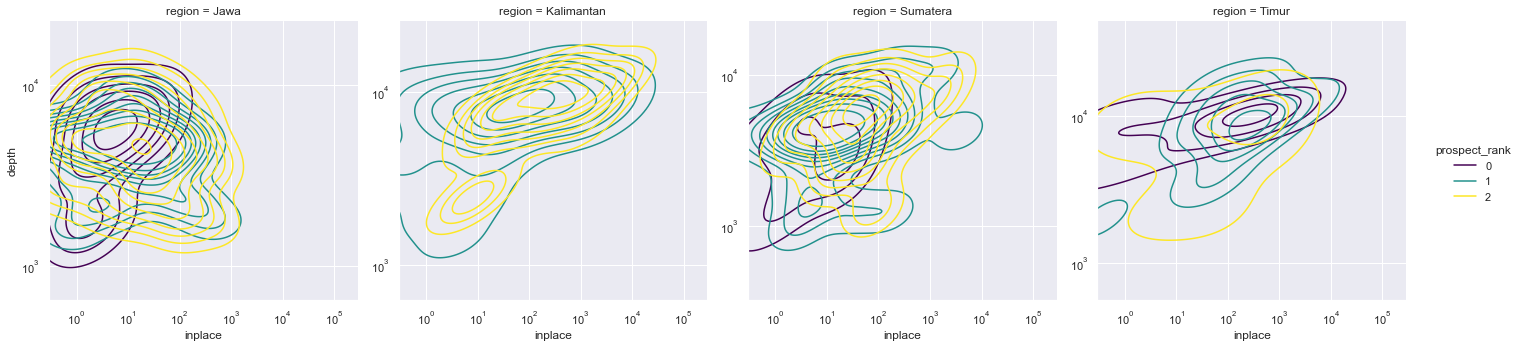

In [61]:
sns.displot(data=esdc_feat_df.loc[esdc_feat_df.fluid == 'Gas', :], x='inplace', y='depth', col='region', hue='prospect_rank', kind='kde',
                palette='viridis', log_scale=True, facet_kws=dict(sharey=False));

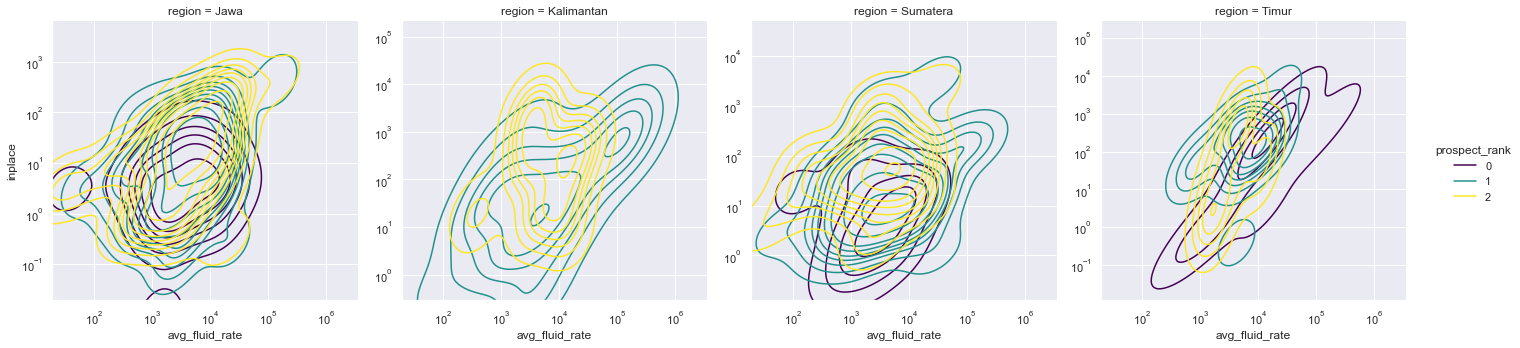

In [62]:
sns.displot(data=esdc_feat_df.loc[esdc_feat_df.fluid == 'Gas', :], x='avg_fluid_rate', y='inplace', col='region', hue='prospect_rank', kind='kde',
                palette='viridis', log_scale=True, facet_kws=dict(sharey=False));

> As we spot earlier on previous analysis that `region` plays a crucial role masking `prospect_rank` clasification using `depth`, `inplace`, and `avg_fluid_rate` when `fluid`==Gas. On above plots, we are convinced that 1 region (timur) is probably the reason causing this issue. When all others region shows consistent trend reflecting good and rational relationship between `depth`, `inplace`, `avg_fluid_rate` on `prospect_rank`, but `region`==Timur shows the opposite. This information/ our hypothesis from data relates to actual condition where market potential for gas on eastern indonesia (timur) is very limited, therefore a good relationship between `depth`, `inplace`, `avg_fluid_rate` on `prospect_rank are` not shown clearly.

__Effect of inplace, rate, and Project_status (location) on prospect_rank__

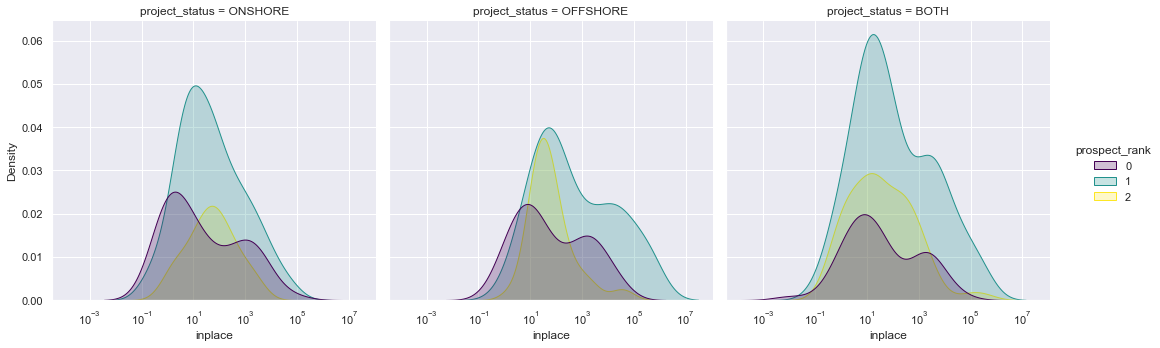

In [63]:
sns.displot(data=esdc_feat_df, x='inplace', col='project_status', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);

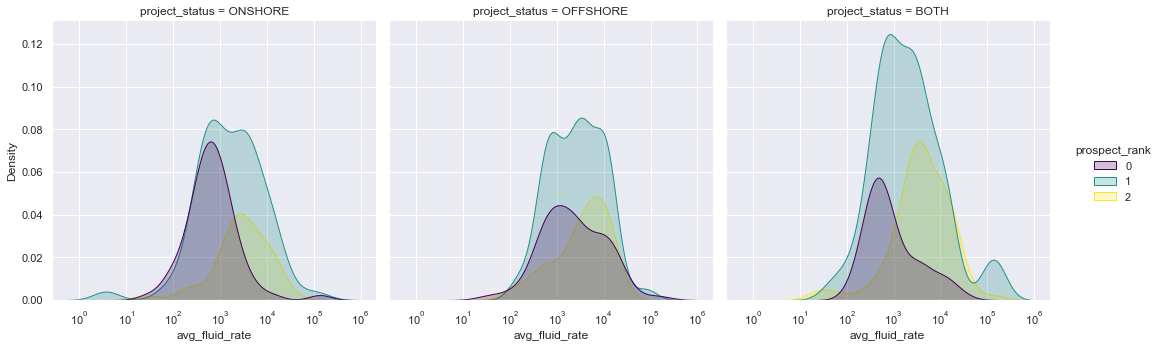

In [64]:
sns.displot(data=esdc_feat_df, x='avg_fluid_rate', col='project_status', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);

> On two plots above we spot many insights that explain how both `inplace` and `avg_fluid_rate` could be a valuable predictor:
- First, we notice that when we have bigger `inplace` it improve our chance to have Medium `prospect_rank` (1) but not High `prospect_rank` (2) where this economic value might only exists on `inplace` range between 10 - 1000 MMBO.E whenever our field is located on offshore/ onshore/ both for all fluid type.
- Second, `avg_fluid_rate` plays significant role since it can reveal very insightful notions that by having higher rate we are inclined to have better economic value for all project location and fluid type.
- Third, `avg_fluid_rate` >= 1000 BOPD.E could be considered as fundamental rate cut off, whenever we pass this value we are inclined to have profitable field but some concern remains that on `project_status`==Offshore, probably, we need additional variable than single `avg_fluid_rate` in order to spot a better cut off as minimum hydrocarbon fluid rate.

> So, when we have a new field, by ensuring this field to deliver significant high rate (above 1000 BOPD.E) might lead us to get a better chance having profitable oil/ gas field regardless their location and fluid type.

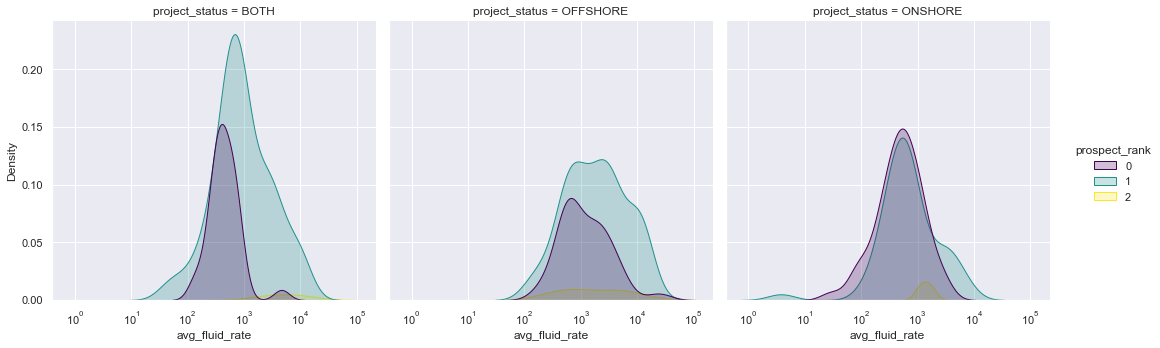

In [84]:
sns.displot(data=esdc_feat_df.loc[(esdc_feat_df.fluid == 'Oil') | (esdc_feat_df.fluid == 'Oil-Gas'), :], x='avg_fluid_rate', col='project_status', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);

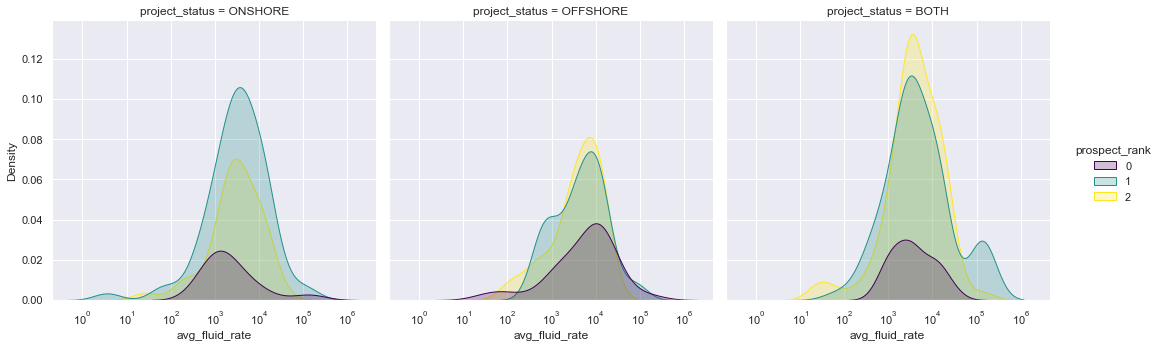

In [66]:
sns.displot(data=esdc_feat_df.loc[esdc_feat_df.fluid == 'Gas', :], x='avg_fluid_rate', col='project_status', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);

> Looking forward on more detailed analysis after figuring out that `avg_fluid_rate` could be used as strong predictor explaining `prospect_rank` when rate is above 1000 BOPD.E, although showing minor effect on offshore location for gas only fluid type (shown on 2 plots above), we intended to expand the analysis by breaking down offshore projects according to their `fluid`==Gas and their `region`, as shown on plot below:

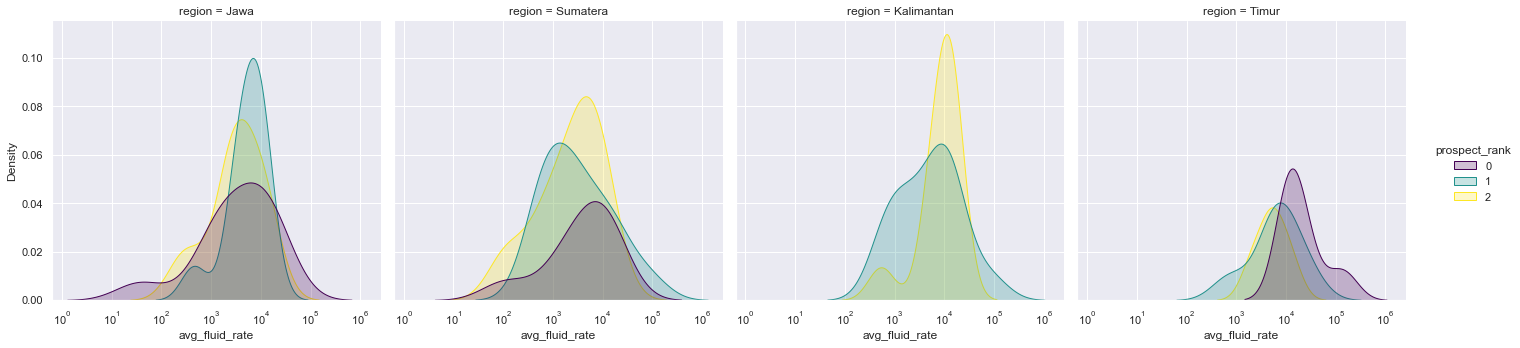

In [68]:
sns.displot(data=esdc_feat_df.loc[(esdc_feat_df.fluid == 'Gas') & (esdc_feat_df.project_status == 'OFFSHORE'), :], x='avg_fluid_rate', col='region', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);


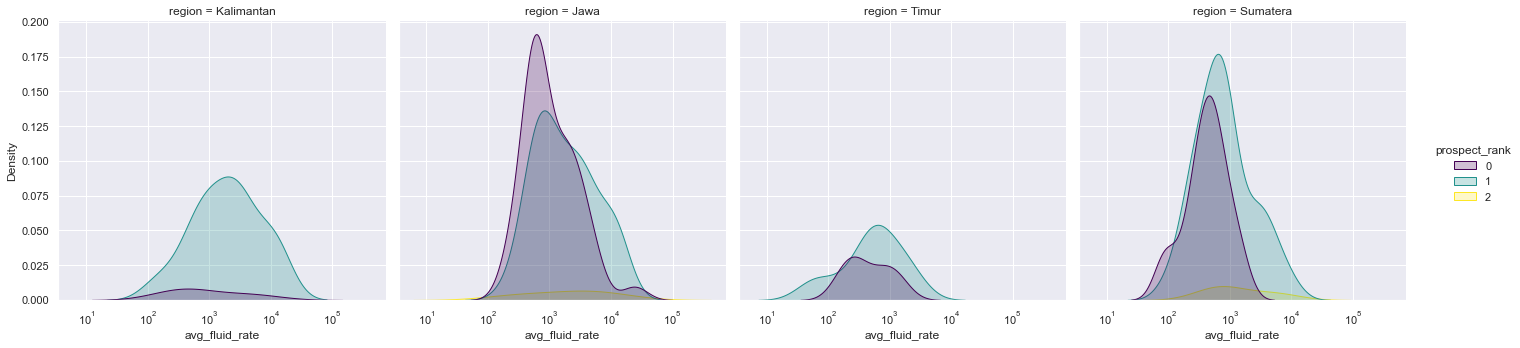

In [75]:
sns.displot(data=esdc_feat_df.loc[(esdc_feat_df.fluid == 'Oil') | (esdc_feat_df.fluid == 'Oil-Gas') & (esdc_feat_df.project_status == 'OFFSHORE'), :], x='avg_fluid_rate', col='region', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);


> We obtained many meaningful informations by using 2 plots above:
- Kalimantan is the most preferable `region` to produce hidrocarbon on offshore, whenever the `avg_fluid_rate`, We might have profitable oil & gas field, especially when `avg_fluid_rate` > 1000 BOPD.E.
- `avg_fluid_rate` >= 1000 BOPD.E could be used as profitable economic cutoff for `fluid`==Oil & `fluid`==Oil&Gas and any kind of regions and locations (second plot above)
- Beside Kalimantan, all gas field projects on offshore have strong tendency to be less profitable when those fields could produce over 1000 BOPD.E. It might be an early indication that those regions have market/ infrastructure issues related to gas. These issues are important and deserve more troughout analysis on modeling.

__Effect of rate, and operatorship on prospect_rank__

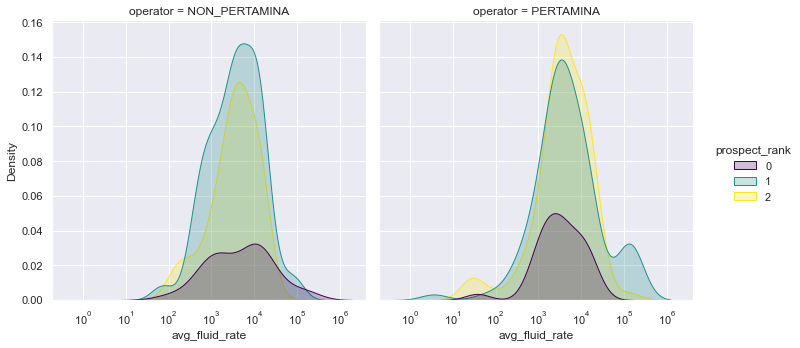

In [63]:
sns.displot(data=esdc_feat_df.loc[esdc_feat_df.fluid == 'Gas', :], x='avg_fluid_rate', col='operator', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);

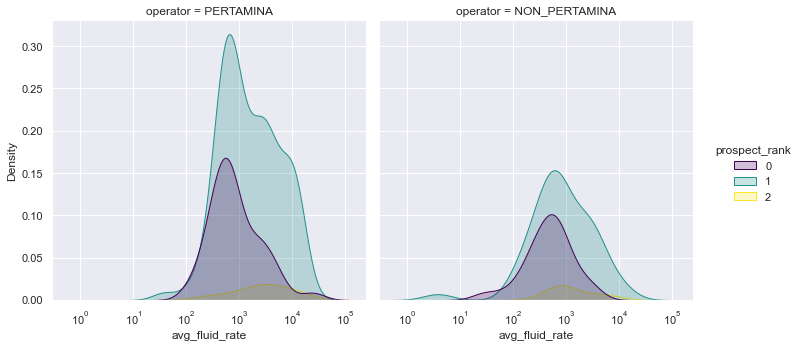

In [77]:
sns.displot(data=esdc_feat_df.loc[esdc_feat_df.fluid == 'Oil-Gas', :], x='avg_fluid_rate', col='operator', hue='prospect_rank', kind='kde', fill=True, palette='viridis', log_scale=True);

> Those 2 plots above imply that:
- Since Pertamina has more diverse field than others it might improve Pertamina's portofolio
- When it comes to gas field, more projects have better profitability under Pertamina than others. This condition might exist probably because of project integration, market readiness, and sound infrastructure alignment inside Pertamina business unit
- On oil project, neither Pertamina nor Others could deliver better performance on profitabilty but we might use `avg_fluid_rate` > 1000 BOPD.E as economic cutoff.

> General Conclusion from EDA:
1. We suspect there is a causal effect of `inplace` & `avg_fluid_rate` in `prospect_rank`. While we segmented on `fluid` we notice that by having bigger `inplace` and `avg_fluid_rate` could lead us to more preferable economic of scale benefit
2. When fields are having a deeper reservoir target they need either bigger `inplace` or `avg_fluid_rate` in order to become more economical.
3. We suspect on `Gas` that either `region` or `location` could play major role to spot non market potential area/ region.
4. When all others region shows consistent trend reflecting good and rational relationship between `depth`, `inplace`, `avg_fluid_rate` on `prospect_rank`, but `region`==Timur shows the opposite. This information/ our hypothesis from data relates to actual condition where market potential for gas on eastern indonesia (timur) is very limited, therefore a good relationship between `depth`, `inplace`, `avg_fluid_rate` on `prospect_rank are` not shown clearly.
5. When we have a new field, by ensuring this field to deliver significant high rate (above 1000 BOPD.E) might lead us to get a better chance having profitable project regardless their location if fluid type is oil but it might not work for gas if it is located at offshore.
6. Kalimantan is the most preferable `region` to produce hidrocarbon on offshore, whenever the `avg_fluid_rate`, We might have profitable project, especially when `avg_fluid_rate` > 1000 BOPD.E.
7. `avg_fluid_rate` >= 1000 BOPD.E could be used as profitable economic cutoff for `fluid`==Oil & `fluid`==Oil&Gas on any kind of regions and location.
8. Beside Kalimantan, all gas field projects on offshore have strong tendency to be less profitable when those fields could produce over 1000 BOPD.E. It might be an early indication that those regions have market/ infrastructure issues related to gas.
9. Since Pertamina has more diverse field than others it might improve Pertamina's portofolio
10. When it comes to gas project, more projects have better profitability under Pertamina than others. This condition might exist probably because of project integration, market readiness, and sound infrastructure alignment inside Pertamina business unit
11. On oil project, neither Pertamina nor others could deliver better performance on profitabilty but we might use `avg_fluid_rate` > 1000 BOPD.E as economic cutoff.

---
__Data Transformation__

In [103]:
esdc_feat_df.head()

,fluid,operator,project_status,inplace,depth,temp,poro,perm,saturate,api_dens,visc,avg_fluid_rate,location,region,prospect_rank
0,Gas,NON_PERTAMINA,ONSHORE,50.000000,5627.0,97.537911,0.231540,396.2948,0.544649,0.654735,0.0,10917.176786,Jawa Timur,Jawa,1
1,Gas,PERTAMINA,OFFSHORE,0.892857,1588.0,60.754449,0.371649,975.0449,0.586189,0.769757,0.0,1475.114107,Jawa Barat,Jawa,0
2,Gas,PERTAMINA,OFFSHORE,3.091071,3775.0,84.004423,0.350870,1985.5620,0.627856,0.774667,0.0,37.480696,Jawa Barat,Jawa,0
3,Gas,PERTAMINA,BOTH,1274.107143,6383.0,76.450000,0.201267,619.7617,0.681374,0.783749,0.0,2827.476786,Selat Makasar,Kalimantan,2
4,Gas,NON_PERTAMINA,ONSHORE,2.839286,2067.0,67.053312,0.213011,108.1771,0.701410,0.710626,0.0,1237.484821,Riau,Sumatera,1


In [106]:
from collections import Counter

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        try:
            df[var_name].hist(bins=40,ax=ax,color = 'green',alpha=0.5, figsize = (15, 24), density=True)
        except:
            cnt = Counter(df[var_name])
            cnt.hist(bins=40,ax=ax,color = 'red',alpha=0.5, figsize = (15, 24), density=True)
        ax.set_title(var_name, fontsize = 10)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = 8)
        ax.set_xlabel('')
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])  # Improves appearance a bit.
    plt.show()

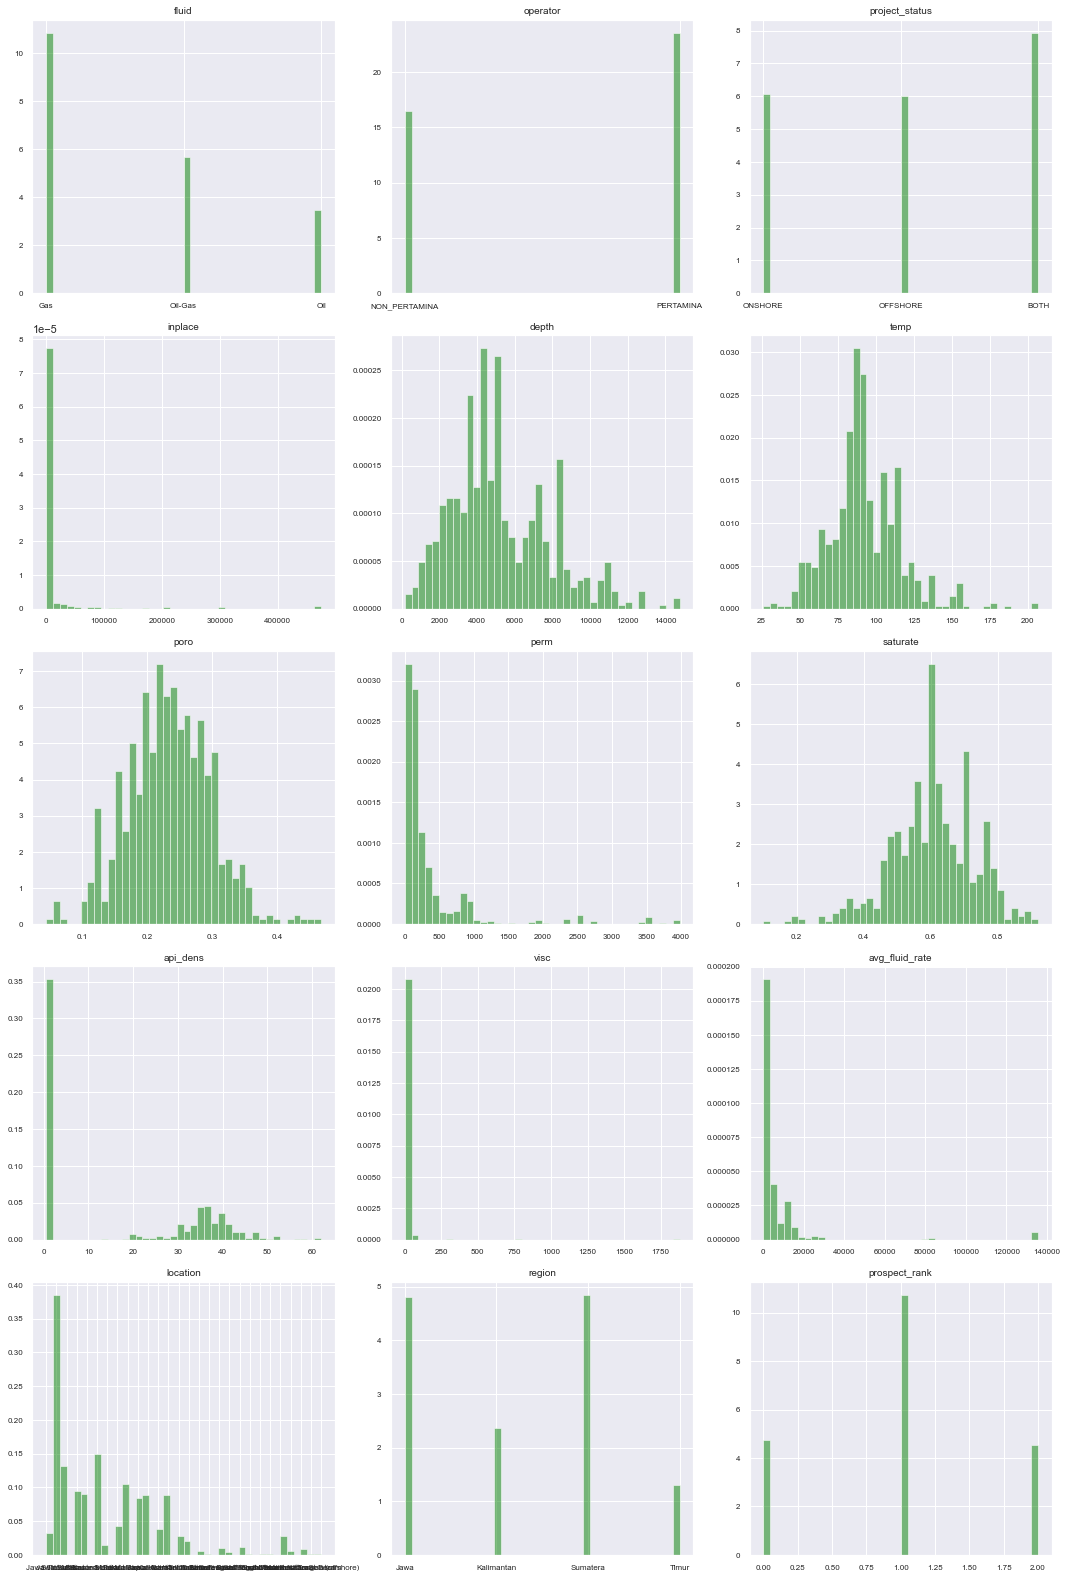

In [107]:
draw_histograms(esdc_feat_df, esdc_feat_df.columns, 5, 3)

> _Target Variable_

In [129]:
target = esdc_feat_df.loc[:, 'prospect_rank']
pd.DataFrame(target.head())

,prospect_rank
0,1
1,0
2,0
3,2
4,1


> _Numerical Transformation_

In [109]:
num_esdc_feat_df = esdc_feat_df._get_numeric_data()
num_esdc_feat_df.drop(columns=['prospect_rank'], inplace=True)
num_esdc_feat_df.head()

,inplace,depth,temp,poro,perm,saturate,api_dens,visc,avg_fluid_rate
0,50.000000,5627.0,97.537911,0.231540,396.2948,0.544649,0.654735,0.0,10917.176786
1,0.892857,1588.0,60.754449,0.371649,975.0449,0.586189,0.769757,0.0,1475.114107
2,3.091071,3775.0,84.004423,0.350870,1985.5620,0.627856,0.774667,0.0,37.480696
3,1274.107143,6383.0,76.450000,0.201267,619.7617,0.681374,0.783749,0.0,2827.476786
4,2.839286,2067.0,67.053312,0.213011,108.1771,0.701410,0.710626,0.0,1237.484821


> We are not going to apply any transformation on numerical data since it will allow us to have an explainable models

> _Categorical Transformation_

In [126]:
cat_esdc_feat_df = esdc_feat_df.drop(columns=num_esdc_feat_df.columns)
cat_esdc_feat_df.drop(columns=['prospect_rank'], inplace=True)
cat_esdc_feat_df.head()

,fluid,operator,project_status,location,region
0,Gas,NON_PERTAMINA,ONSHORE,Jawa Timur,Jawa
1,Gas,PERTAMINA,OFFSHORE,Jawa Barat,Jawa
2,Gas,PERTAMINA,OFFSHORE,Jawa Barat,Jawa
3,Gas,PERTAMINA,BOTH,Selat Makasar,Kalimantan
4,Gas,NON_PERTAMINA,ONSHORE,Riau,Sumatera


In [130]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

In [131]:
hot_cat_esdc_feat_df = cat_encoder.fit_transform(cat_esdc_feat_df)
hot_cat_esdc_feat_df

<734x40 sparse matrix of type '<class 'numpy.float64'>'
	with 3670 stored elements in Compressed Sparse Row format>

In [134]:
hot_cat_esdc_feat_df_ = hot_cat_esdc_feat_df.toarray()
hot_cat_esdc_feat_df_

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [135]:
cat_encoder.categories_

[array(['Gas', 'Oil', 'Oil-Gas'], dtype=object),
 array(['NON_PERTAMINA', 'PERTAMINA'], dtype=object),
 array(['BOTH', 'OFFSHORE', 'ONSHORE'], dtype=object),
 array(['Aceh', 'Jambi', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur',
        'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur',
        'Kalimantan Utara', 'Laut Cina Utara', 'Laut Jawa', 'Laut Natuna',
        'Laut Natuna Utara', 'Laut Seram', 'Laut Timor', 'Maluku',
        'Papua Barat', 'Riau', 'Selat Makasar', 'Selat Malaka',
        'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah',
        'Sulawesi Tengah (offshore)', 'Sumatera Barat', 'Sumatera Selatan',
        'Sumatera Utara', 'Teluk Berau'], dtype=object),
 array(['Jawa', 'Kalimantan', 'Sumatera', 'Timur'], dtype=object)]

> _Data Consolidation_

In [136]:
cat_columns = ['Gas', 'Oil', 'Oil-Gas',
            'NON_PERTAMINA', 'PERTAMINA', 
            'BOTH', 'OFFSHORE', 'ONSHORE', 
            'Aceh', 'Jambi', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur',
            'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur',
            'Kalimantan Utara', 'Laut Cina Utara', 'Laut Jawa', 'Laut Natuna',
            'Laut Natuna Utara', 'Laut Seram', 'Laut Timor', 'Maluku',
            'Papua Barat', 'Riau', 'Selat Makasar', 'Selat Malaka',
            'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah',
            'Sulawesi Tengah (offshore)', 'Sumatera Barat', 'Sumatera Selatan',
            'Sumatera Utara', 'Teluk Berau', 
            'Jawa', 'Kalimantan', 'Sumatera', 'Timur']

In [137]:
tr_df_cat = pd.DataFrame(hot_cat_esdc_feat_df_, columns=cat_columns)

In [140]:
tr_esdc_feat_df = pd.concat((num_esdc_feat_df, tr_df_cat, target), axis=1)
tr_esdc_feat_df.head()

,inplace,depth,temp,poro,perm,saturate,api_dens,visc,avg_fluid_rate,Gas,Oil,Oil-Gas,NON_PERTAMINA,PERTAMINA,BOTH,OFFSHORE,ONSHORE,Aceh,Jambi,Jawa Barat,Jawa Tengah,Jawa Timur,Kalimantan Selatan,Kalimantan Tengah,Kalimantan Timur,Kalimantan Utara,Laut Cina Utara,Laut Jawa,Laut Natuna,Laut Natuna Utara,Laut Seram,Laut Timor,Maluku,Papua Barat,Riau,Selat Makasar,Selat Malaka,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tengah (offshore),Sumatera Barat,Sumatera Selatan,Sumatera Utara,Teluk Berau,Jawa,Kalimantan,Sumatera,Timur,prospect_rank
0,50.000000,5627.0,97.537911,0.231540,396.2948,0.544649,0.654735,0.0,10917.176786,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,0.892857,1588.0,60.754449,0.371649,975.0449,0.586189,0.769757,0.0,1475.114107,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,3.091071,3775.0,84.004423,0.350870,1985.5620,0.627856,0.774667,0.0,37.480696,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,1274.107143,6383.0,76.450000,0.201267,619.7617,0.681374,0.783749,0.0,2827.476786,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
4,2.839286,2067.0,67.053312,0.213011,108.1771,0.701410,0.710626,0.0,1237.484821,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


---
__Features Ready Dataset__

In [141]:
tr_esdc_feat_df.to_csv('Data/tr_esdc_feat_df.csv', index=False)

---
__Data Splitting__

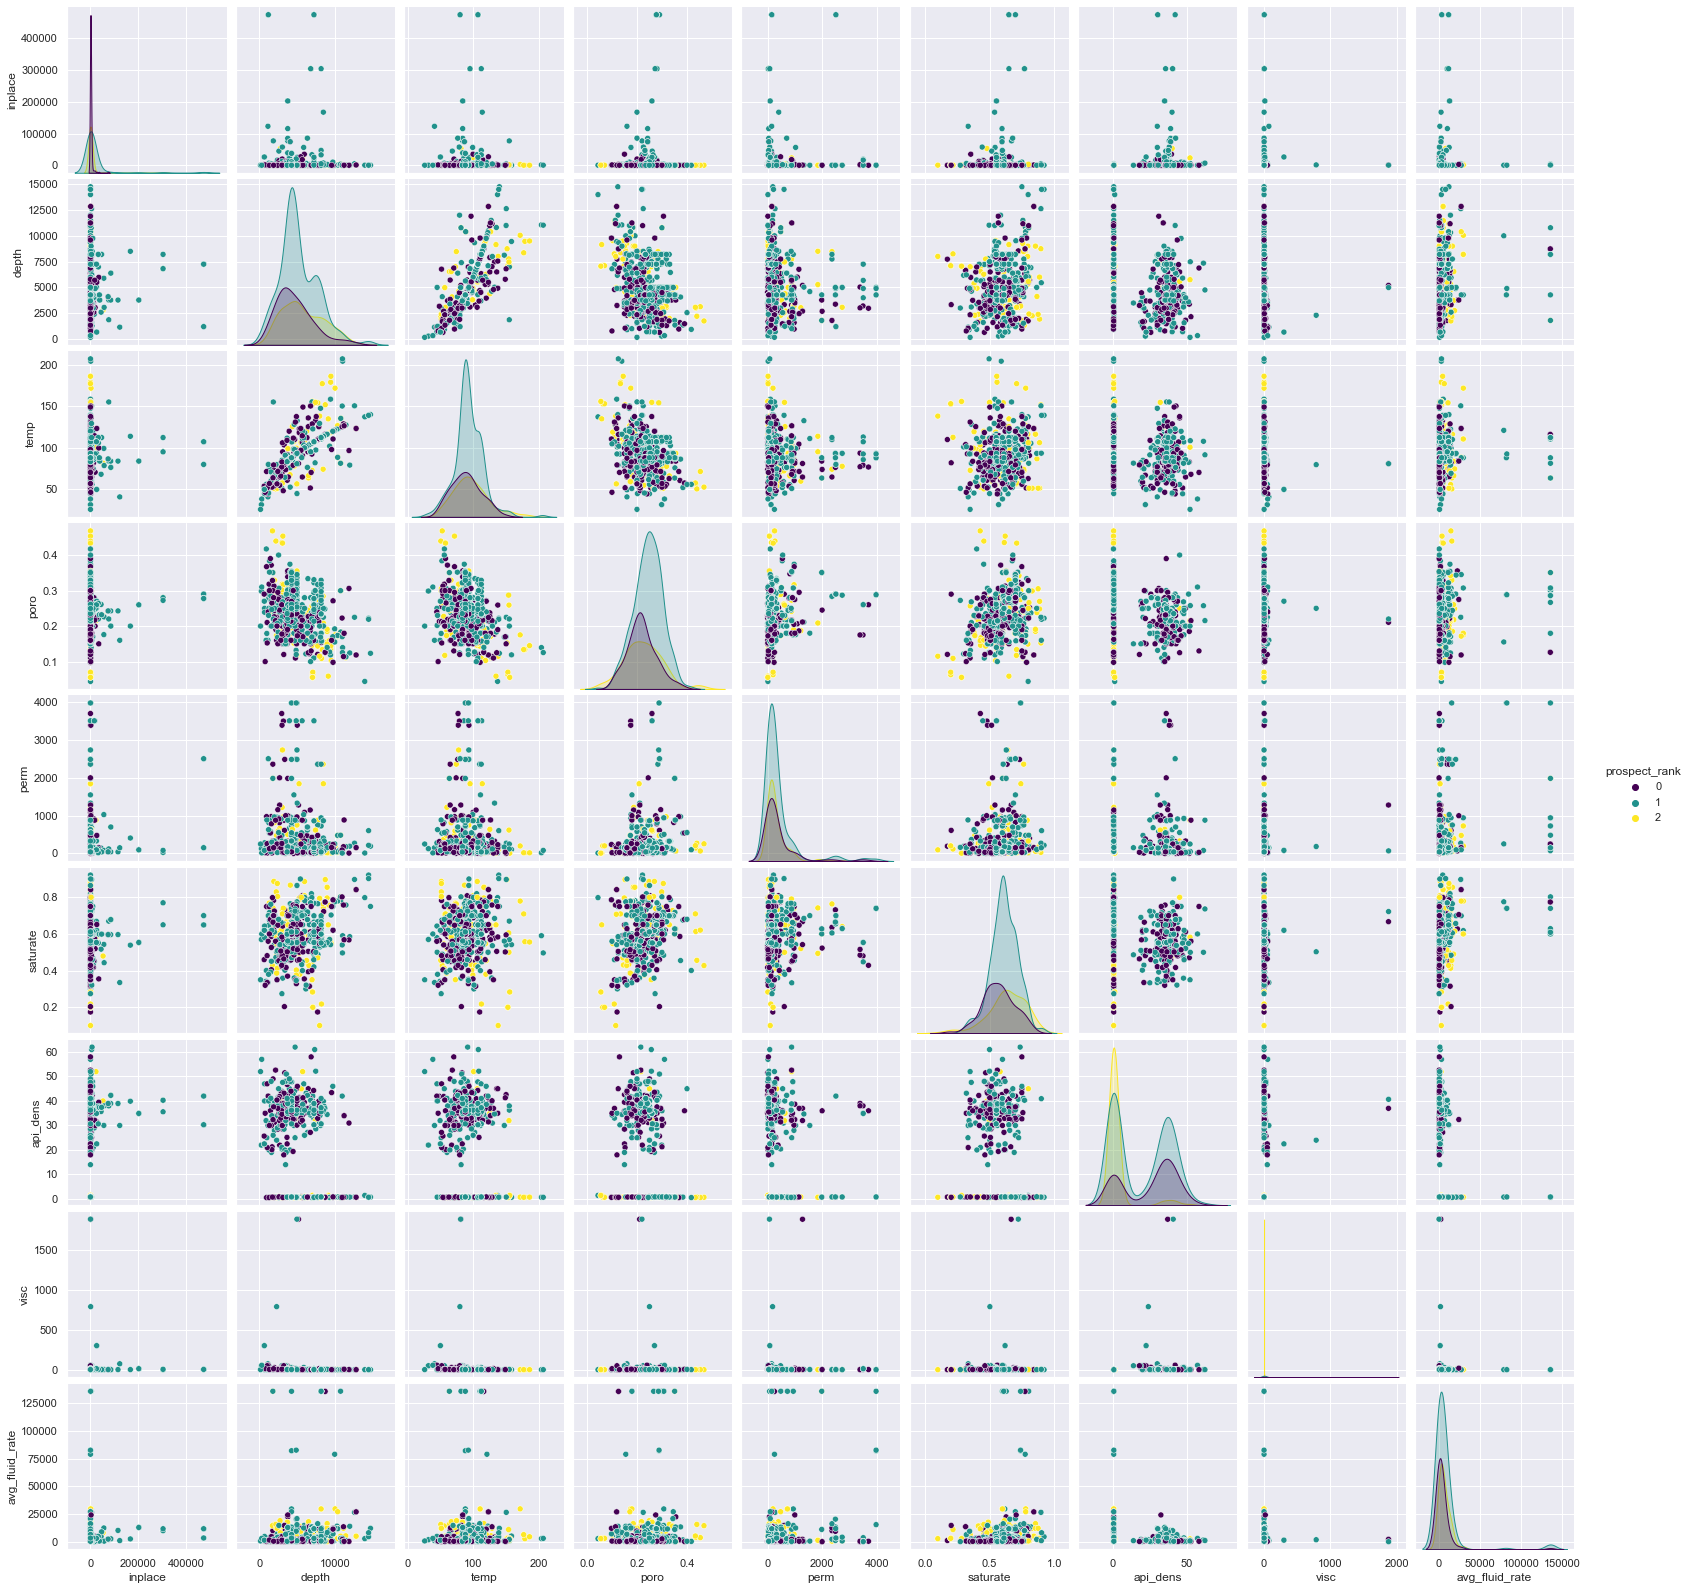

In [148]:
sns.pairplot(pd.concat((num_esdc_feat_df, target), axis=1), hue='prospect_rank', palette='viridis');

In [153]:
from sklearn.model_selection import  StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(tr_esdc_feat_df, tr_esdc_feat_df.prospect_rank):
 strat_train_set = tr_esdc_feat_df.loc[train_index]
 strat_test_set = tr_esdc_feat_df.loc[test_index]


> Data for Training

In [163]:
Esdc_train, Esdc_train_target = strat_train_set.loc[:, 'inplace' : 'Timur'], strat_train_set.loc[:, 'prospect_rank']

> Data for Testing

In [164]:
esdc_test, esdc_test_target = strat_test_set.loc[:, 'inplace' : 'Timur'], strat_test_set.loc[:, 'prospect_rank']

> Data Drifting Evaluation

>> On this chapter we are going to conduct drifting analysis to check whether our data after splitting still have similar data distribution compared to their parent, for this case the parent is `tr_esdc_feat_df`.

In [178]:
from collections import Counter

def drifting_histograms(df, dfs, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        try:
            df[var_name].hist(bins=40,ax=ax,color = 'green',alpha=0.5, figsize = (15, 24), density=True)
            dfs[var_name].hist(bins=40,ax=ax,color = 'r',alpha=0.5, figsize = (15, 24), density=True)
        except:
            cnt = Counter(df[var_name])
            cnts = Counter(dfs[var_name])
            cnt.hist(bins=40,ax=ax,color = 'green',alpha=0.5, figsize = (15, 24), density=True)
            cnts.hist(bins=40,ax=ax,color = 'r',alpha=0.5, figsize = (15, 24), density=True)

        ax.set_title(var_name, fontsize = 10)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = 8)
        ax.set_xlabel('')
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])  # Improves appearance a bit.
    plt.show()

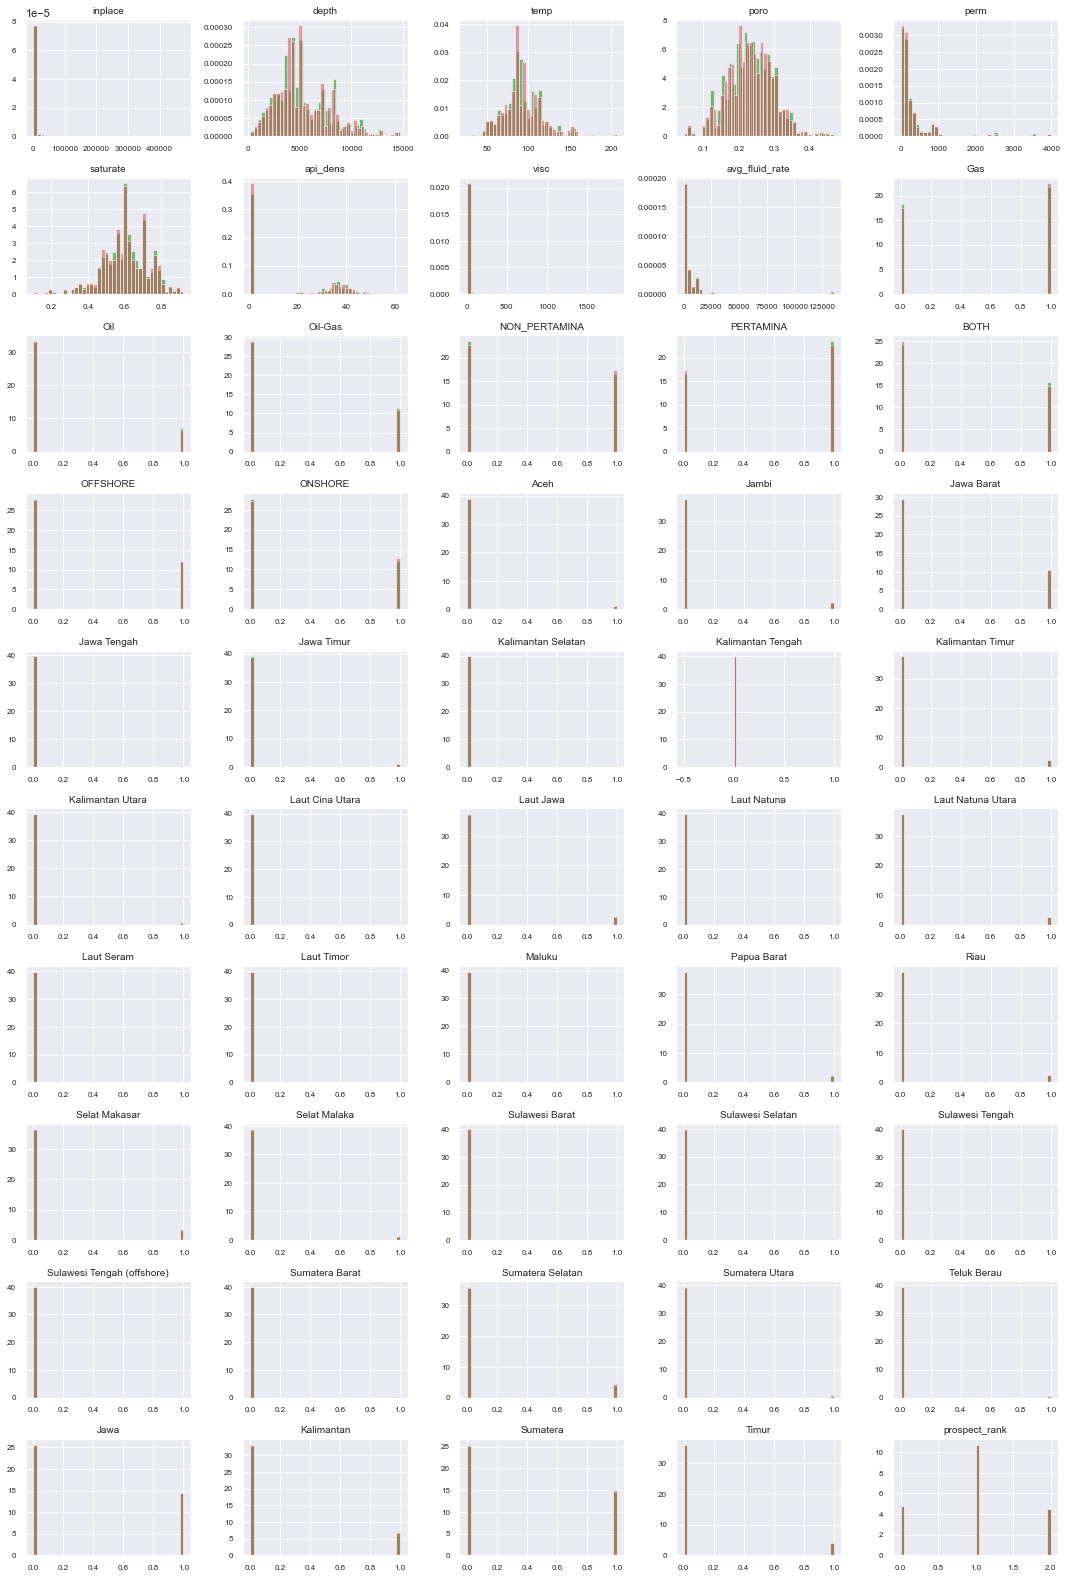

In [179]:
drifting_histograms(tr_esdc_feat_df, strat_train_set, tr_esdc_feat_df.columns, 10, 5)

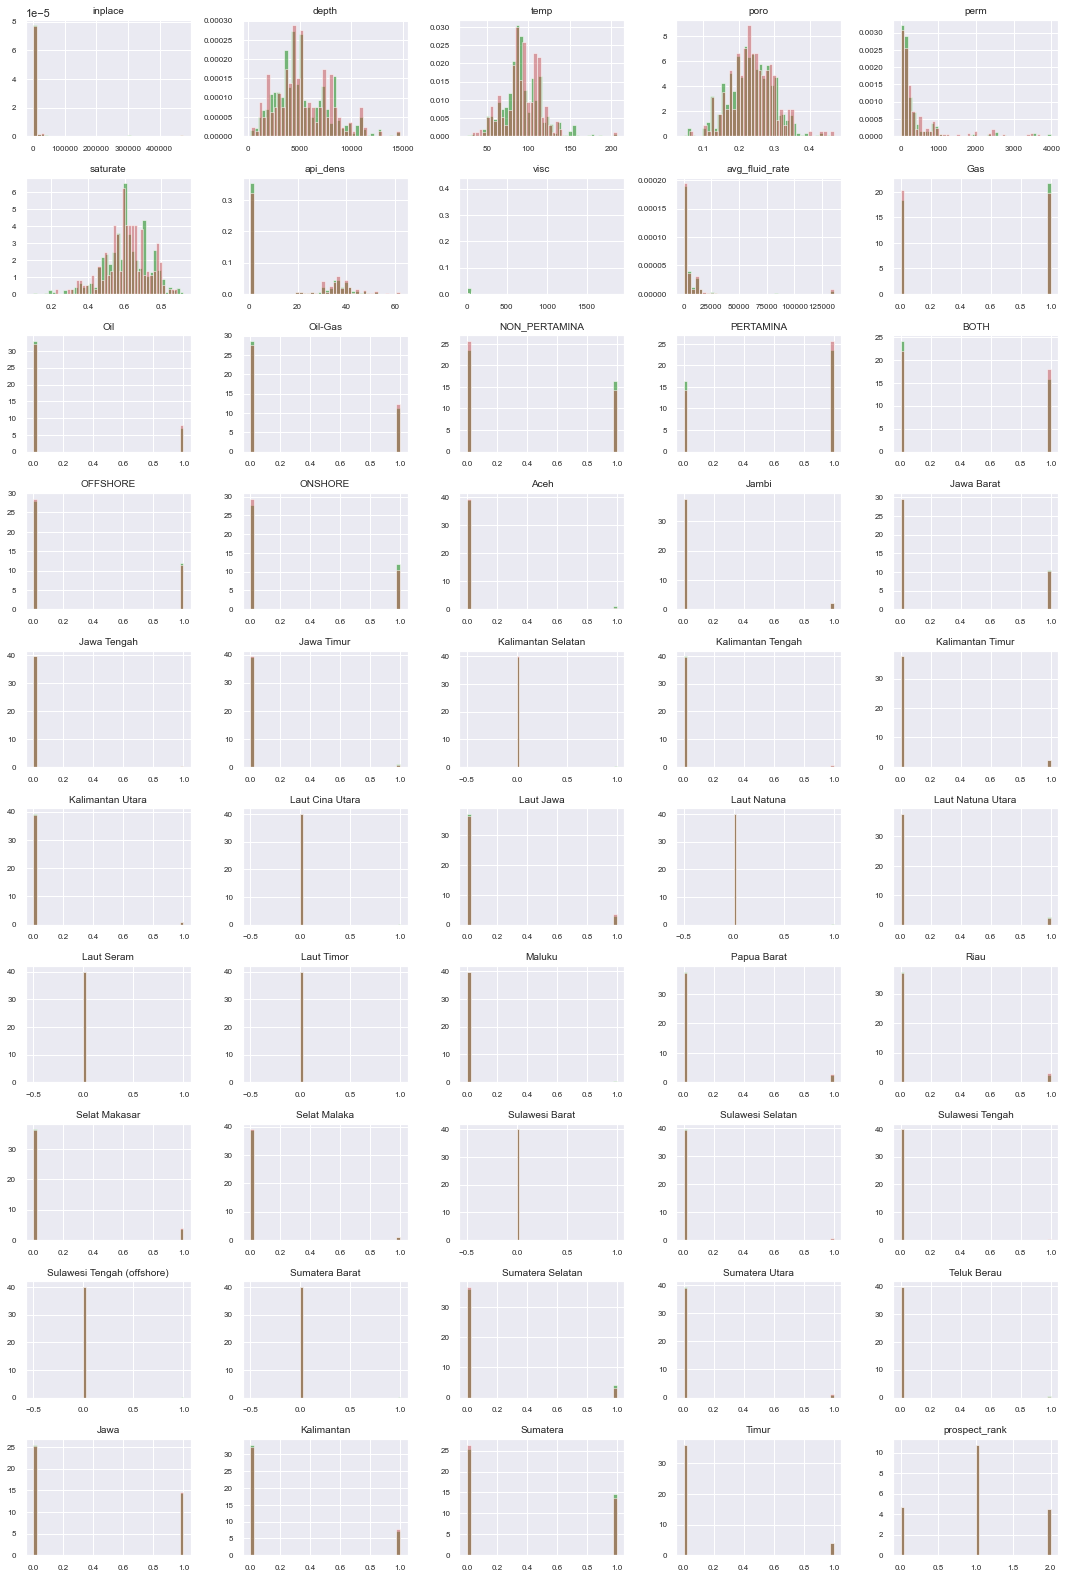

In [180]:
drifting_histograms(tr_esdc_feat_df, strat_test_set, tr_esdc_feat_df.columns, 10, 5)

---
__ML Training__

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score

__Baseline Model Checking__

In [216]:
# Check the baseline model
def baseline_model(X_train,y_train):
  clf_logreg = LogisticRegression(multi_class='multinomial').fit(X_train,y_train)
  clf_rf = RandomForestClassifier().fit(X_train,y_train)
  clf_tree = DecisionTreeClassifier().fit(X_train,y_train)
  clf_knn = KNeighborsClassifier().fit(X_train,y_train)
  clf_lgbm = LGBMClassifier().fit(X_train,y_train)
  clf_xgb = xgb.XGBClassifier().fit(X_train,y_train)

  gini_logreg = (2*(roc_auc_score(y_train, clf_logreg.predict_proba(X_train), multi_class='ovr')))-1
  gini_rf = (2*(roc_auc_score(y_train, clf_rf.predict_proba(X_train), multi_class='ovr')))-1
  gini_tree = (2*(roc_auc_score(y_train, clf_tree.predict_proba(X_train), multi_class='ovr')))-1
  gini_knn = (2*(roc_auc_score(y_train, clf_knn.predict_proba(X_train), multi_class='ovr')))-1
  gini_lgbm = (2*(roc_auc_score(y_train, clf_lgbm.predict_proba(X_train), multi_class='ovr')))-1
  gini_xgb = (2*(roc_auc_score(y_train, clf_xgb.predict_proba(X_train), multi_class='ovr')))-1

  print("Gini Performance Evaluation\n")
  print(f"Logistic Regression Gini : {gini_logreg}")
  print(f"Random Forest Gini       : {gini_rf}")
  print(f"Decision Tree Gini       : {gini_tree}")
  print(f"KNN Classifier Gini      : {gini_knn}")
  print(f"LGBM Gini                : {gini_lgbm}")
  print(f"XGBoost Gini             : {gini_xgb}")

  return clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb
 
clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb = baseline_model(Esdc_train,Esdc_train_target)

C:\Users\andip\Anaconda3\envs\fld_prob_indx\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gini Performance Evaluation

Logistic Regression Gini : 0.3466117549839207
Random Forest Gini       : 0.9953782178252177
Decision Tree Gini       : 0.9972428895326759
KNN Classifier Gini      : 0.6649081623053561
LGBM Gini                : 0.9971790885805696
XGBoost Gini             : 0.9972428895326759
